In [ ]:
# Import libraries
import os
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import numpy as np
import math
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import geopandas as gpd
import contextily as ctx

import folium

import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq
from dateutil import parser
import zipfile
from collections import Counter

from modules.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, URL_LIST, POLLUTANTS, MUNICIPALITY

WATER_QUALITY_FILE = "water_quality_data.xlsb"
SUBDIR = "../data/raw/"
ALL_POLLUTANTS = [
 'ALC_FEN',
 'ALC_TOT',
 'CO3',
 'HCO3',
 'OH',
 'CLOROF_A',
 'COLI_FEC',
 'COLI_TOT',
 'E_COLI',
 'COT',
 'COT_SOL',
 'DBO_SOL',
 'DBO_TOT',
 'DQO_SOL',
 'DQO_TOT',
 'N_NH3',
 'N_NO2',
 'N_NO3',
 'N_ORG',
 'N_TOT',
 'N_TOTK',
 'TOX_D_48_UT',
 'TOX_D_48_SUP_UT',
 'TOX_D_48_FON_UT',
 'TOX_FIS_SUP_15_UT',
 'TOX_FIS_SUP_30_UT',
 'TOX_FIS_SUP_5_UT',
 'TOX_FIS_FON_15_UT',
 'TOX_FIS_FON_30_UT',
 'TOX_FIS_FON_5_UT',
 'TOX_V_15_UT',
 'TOX_V_30_UT',
 'TOX_V_5_UT',
 'AOXF',
 'AOXP',
 'AOXT',
 'P_TOT',
 'PO4_TOT',
 'ORTO_PO4',
 'COLOR_VER',
 'TRANSPARENCIA',
 'ABS_UV',
 'SDT',
 'CONDUC_CAMPO',
 'CONDUC_CAMPO_SUP',
 'CONDUC_CAMPO_MED',
 'CONDUC_CAMPO_FON',
 'pH_CAMPO',
 'pH_CAMPO_SUP',
 'pH_CAMPO_MED',
 'pH_CAMPO_FON',
 'SALINIDAD_SUP',
 'SALINIDAD_MED',
 'SALINIDAD_FON',
 'OD_%',
 'OD_mg/L',
 'OD_%_SUP',
 'OD_mg/L_SUP',
 'OD_%_MED',
 'OD_mg/L_MED',
 'OD_%_FON',
 'OD_mg/L_FON',
 '1,1,1,2_TTCETA',
 '1,1,2,2_TETRACLETAN',
 '1,1,2_TCETA',
 '1,1_DICLETILEN',
 '1,2,4_TRICLBENCEN',
 '1,2_DIBR_3_CLPROPAN',
 '1,2_DICLETAN',
 '1,2_DICLPROPAN',
 '1,2_DIFENILHIDRACINA',
 '1_C_NAF',
 '2,3_DICLOROFENOL_DCF',
 '2,4,5_T',
 '2,4,5_TRICLOROFENOL',
 '2,4,6_TRICLFENOL',
 '2,4_D_D_C_FENOXIACETICO',
 '2,4_DICLFENOL',
 '2,4_DIMETILFEN',
 '2,4_DINITOL',
 '2,4_DNF',
 '2,6_DINTOL',
 '2_CEVE',
 '2_CF',
 '2_CLNAFT',
 '2_NIFENOL',
 '4_BRFENFENETER',
 '4_NITROFENOL',
 'ACENAF',
 'ACENAFTIL',
 'ANTRA',
 'BEN_A_ANT',
 'BEN_A_PIR',
 'BEN_B_FANT',
 'BEN_G,H,I_PER',
 'BEN_K_FANT',
 'CRISENO',
 'DIBEN_ANT',
 'FENANTRENO',
 'FLUORANTENO',
 'FLUORENO',
 'IND_PIR',
 'NAFTALENO',
 'PIRENO',
 'HAPS',
 'ACRILONITRILO',
 'ACROLEINA',
 'AL_TOT',
 'ALACLOR',
 'ALDICARB',
 'ALDRIN',
 'ATRAZINA',
 'B_TOT',
 'B2_ETILHEXIL_FTALATO',
 'BA_TOT',
 'BE_TOT',
 'BENCENO',
 'BENCIDINA',
 'BIS2_CLETETER',
 'BIS2_CLIOISOPET',
 'BOLSTAR',
 'BPCS',
 'BR_CLMET',
 'BROMOMETANO',
 'CARBOFURANO',
 'CIS_1,2_DICLETEN',
 'CL_BENC',
 'CL_METILENO',
 'CL_RES',
 'CLORATALONIL',
 'CLORDANO',
 'CLOROMETANO',
 'CLOROTOLURON',
 'CLORPIRYFOS',
 'CLORURO_DE_VINILO',
 'CLORUROS_TOT',
 'COUMAFOS',
 'CR_HEX',
 'CYANACINA',
 'DALAPON',
 'DDD',
 'DDE',
 'DDT',
 'DELTAMETRINA',
 'DEMETON_S',
 'DI_2_ETILEXIL_ADIPATO',
 'DIAZINON',
 'DICAMBA',
 'DICLORVOS',
 'DIELDRIN',
 'DIET_FTAL',
 'DIMETIL_FTAL',
 'DIMETOATO',
 'DINITRO_O_CRESOL',
 'DINOSEB',
 'DIURON',
 'END_ALD',
 'ENDO_SUL',
 'ALFA_ENDO',
 'BETA_ENDO',
 'ENDO_SULSO4',
 'ENDRIN',
 'ENTEROC_FEC',
 'EPN',
 'ESTIRENO',
 'ETILBENCENO',
 'ETOPROP',
 'FE_TOT',
 'FENITROTION',
 'FENOL',
 'FENOLES_TOT',
 'FENSULFOTION',
 'FENTION',
 'FLUORUROS_TOT',
 'FORATO',
 'GLIFOSATO',
 'GRAS_ACEI',
 'H_HELMINTOS',
 'HEPTA_EPOX',
 'HEPTACLOR',
 'HEXACL_BENC',
 'HEXACL_BUT',
 'HEXACL_CICLOPEN',
 'HEXACL_ETANO',
 'ISO_FOR',
 'ISOPROTURON',
 'K_TOT',
 'LINURON',
 'MALATION',
 'MAT_FLOTANTE',
 'MCPA',
 'MERFOS',
 'METIL_AZINF_GUT',
 'METILPARATION',
 'METILTERBUTILETER_MTBE_',
 'METOLACLOR',
 'METOXICLO',
 'MEVINFOS',
 'MIREX',
 'MN_TOT',
 'MO_TOT',
 'MOLINATO',
 'N_NITROS_DIMETILA',
 'N_NITROS_N_PROPAM',
 'N_NITROSODIFENILAMINA',
 'NA_TOT',
 'NITROBENCENO',
 'OXAMIL',
 'PARATION',
 'PCBEN',
 'PENDIMETALIN',
 'PENTACLOROFENOL',
 'PICLORAN',
 'PIRYPROXYFEN',
 'RONNEL',
 'SAAM',
 'SB_TOT',
 'SE_TOT',
 'SILVEX',
 'SIMAZINA',
 'SIO2',
 'SO4_TOT',
 'SOLID_SED',
 'SST',
 'SULFOTEP',
 'SULFUROS_TOT',
 'TALIO',
 'TERBUFOS',
 'TERBUTILAZINA',
 'TETRACL_CARB',
 'TETRACLOROETILENO_',
 'TOKUTION',
 'TOLUENO',
 'TOXAFENO',
 'TRANS_1,2_DICLOROETILENO',
 'TRIALATO',
 'TRICLORANATO',
 'TRICLORFON',
 'TRICLOROETILENO',
 'TRICLOROFLUOROMETANO',
 'TRIFLURALIN',
 'TURBIEDAD',
 'AS_TOT',
 'CD_TOT',
 'CR_TOT',
 'HG_TOT',
 'NI_TOT',
 'PB_TOT',
 'CN_TOT',
 'CU_TOT',
 'ZN_TOT',
 'POT_REDOX_CAMPO',
 'POT_REDOX_CAMPO_FON',
 'POT_REDOX_CAMPO_MED',
 'POT_REDOX_CAMPO_SUP',
 'ACENAF_8310',
 'ACENAFTIL_8310',
 'ANTRA_8310',
 'BEN_A_ANT_8310',
 'BEN_A_PIR_8310',
 'BEN_B_FANT_8310',
 'BEN_G,H,I_PER_8310',
 'BEN_K_FANT_8310',
 'CRISENO_8310',
 'DIBEN_ANT_8310',
 'FENANTRENO_8310',
 'FLUORANTENO_8310',
 'FLUORENO_8310',
 'IND_PIR_8310',
 'NAFTALENO_8310',
 'PIRENO_8310',
 'HAPS_8310',
 '1,2_DICLBENC',
 '1,3_DICLBEN',
 '1,4_DICLBEN',
 'DICLOROBENCENOS',
 'BR_DICLMET',
 'BROMOF',
 'CLOROFORMO',
 'DIBR_CLMET',
 'THMs',
 'M,P_XILENO',
 'O_XILENO',
 'XILEN_ISOMEROS',
 'ALFA_BHC',
 'BETA_BHC',
 'GAMA_BHC_LIN',
 'DELTA_BHC',
 'BHC_ISOMEROS',
 'CA_TOT',
 'MG_TOT',
 'DUR_TOT',
 'TEMP_AMB',
 'TEMP_AGUA',
 'TEMP_AGUA_SUP',
 'TEMP_AGUA_MED',
 'TEMP_AGUA_FON',
 'PROFUNDIDAD',
 'CAUDAL',
 'CLORUROS_SOL',
 'FLUORUROS_SOL',
 'SO4_SOL',
 'AS_SOL',
 'CD_SOL',
 'CR_SOL',
 'FE_SOL',
 'MN_SOL',
 'HG_SOL',
 'PB_SOL',
 'ZN_SOL',
 'AL_SOL',
 'CU_SOL',
 'TALIO_SOL',
 'NI_SOL',
 'CA_SOL',
 'MG_SOL',
 'K_SOL',
 'NA_SOL',
 'SULFUROS_SOL',
 'BA_SOL',
 'SB_SOL',
 'AG_TOT',
 'S',
 'AMPA',
 'V_TOT',
 'SE',
 'SSV',
 'C.MESÓFILOS AEROBIOS',
 'DUR_Ca',
 'DUR_Mg',
 'NH4',
 'ST',
 'DIBR_MET',
 'DIBROMOETILENO',
 'S_TOT',
 '1,1-DICLOROPROPILENO',
 '1,2,3_TRICLBENCEN',
 '1,2-DIBR_ETA',
 '1,3,5-TRIMETILBENCENO',
 '1,3_DICLPROPAN',
 '2_CLOROTOLUENO',
 '2_METILFEN',
 '4_CLOROTOLUENO',
 '4-ISOPROPILTOLUENO',
 'ALC_A',
 'AZOBENCENO',
 'BIS_2_CLOROETOXI_MET',
 'BISMUTO',
 'BROMATOS',
 'BROMOBENCENO',
 'BUTILBENCILFTALATO',
 'CARBAZOLA',
 'CIS-CLORDANO',
 'CLORAMINAS_COMO_CL2_',
 'CLORITOS',
 'CLOROF_B',
 'CLOROF_C',
 'CO_TOT',
 'COLOR_APA',
 'COLOR_VER_436',
 'COLOR_VER_525',
 'COLOR_VER_620',
 'COMP_ORG_NO_HALOG_FID_CONH',
 'CONDUC_LAB',
 'COP',
 'DIBENZOFURANO',
 'DIBUTILFTALATO (DBP)',
 'DICLOROMETANO',
 'DI-OCTILFTALATO',
 'DIQUAT',
 'ENDOSULFAN II',
 'ENDOTAL',
 'ENDRÍN CETONA',
 'HIDROCAR_F_MED',
 'HIDROCAR_F_PES',
 'ISOPROPILBENCENO',
 'Li_TOT',
 'N_NO3-N_NO2',
 'N_ORG_SOL',
 'N-BUTILBENCENO',
 'N-PROPILBENCENO',
 'O-NITROANILINA',
 'P_INORG',
 'P_INORG_DIS',
 'P_ORG',
 'P-CLOROANILINA',
 'pH_LAB',
 'SALINIDAD ',
 'SDF',
 'SDV',
 'SEC-BUTILBENCENO',
 'SN_TOT',
 'SR_TOT',
 'SSF',
 'STF',
 'STV',
 'TALIO_TOT',
 'TER-BUTILBENCENO',
 'Ti_TOT',
 'TRANS-CLORDANO',
 'FORMALDEHIDO',
 'CLORATOS',
 'ACID_CLOROACE',
 'ACID_DICLOROACE',
 'ACID_TRICLOROACE'
 ]

2024-11-14 12:02:36.187 | INFO     | modules.config:<module>:11 - PROJ_ROOT path is: /mnt/Data/Documents/Unison/1 Semestre/Ingeniería de Características/Projects/Sonora-River-Farming/Data-Science-Project


### Load data
We upload the data from the sites and the results of the measurements of the different pollutants. Merge df_water_site and df_water_result DataFrames using 'CLAVE SITIO' as the key. The 'inner' join returns only rows with matching values in both DataFrames. We select the columns required for the study, and in this case we need to select all the pollulants.

In [4]:
df_water_site = pd.read_excel(SUBDIR + WATER_QUALITY_FILE, sheet_name=0)
df_water_result = pd.read_excel(SUBDIR + WATER_QUALITY_FILE, sheet_name=1, parse_dates=['FECHA REALIZACIÓN'])

/tmp/ipykernel_10436/801284402.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_water_result = pd.read_excel(SUBDIR + WATER_QUALITY_FILE, sheet_name=1, parse_dates=['FECHA REALIZACIÓN'])


In [5]:
# Merging df_water_site and df_water_result DataFrames using 'CLAVE SITIO' as the key.
df_water_merged = pd.merge(
    df_water_site, 
    df_water_result, 
    on='CLAVE SITIO', 
    how='inner'
)

# Select the columns required for the study
df_water_merged_filtered = df_water_merged[
    ['CLAVE SITIO', 'ESTADO', 'MUNICIPIO', 'CUERPO DE AGUA', 'TIPO CUERPO DE AGUA', 'SUBTIPO CUERPO AGUA', 'LATITUD', 'LONGITUD', 'FECHA REALIZACIÓN'] + 
    ALL_POLLUTANTS
]

# Convert the 'FECHA REALIZACIÓN' column to the correct datetime format
# First convert the column to numeric
df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_numeric(df_water_merged_filtered['FECHA REALIZACIÓN'], errors='coerce')

# Then convert to dates from Excel origin
df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_datetime(
    df_water_merged_filtered['FECHA REALIZACIÓN'], 
    origin='1899-12-30', 
    unit='D'
)

# Filter the DataFrame to obtain only the records of the water bodies that are not "COASTAL" of the affected municipalities of the state of Sonora.
df_water_filtered_sonora = df_water_merged_filtered[
    (df_water_merged['ESTADO'] == 'SONORA') &
    (df_water_merged['MUNICIPIO'].isin(MUNICIPALITY))   
]
df_water_filtered_sonora = df_water_filtered_sonora[
    ~df_water_filtered_sonora['TIPO CUERPO DE AGUA'].str.contains('COSTERO', na=False)
]

# Clean the columns of pollutants by removing the '>' and '<' symbols and converting them to numeric
for column in ALL_POLLUTANTS:
    if column in df_water_filtered_sonora.columns:
        df_water_filtered_sonora[column] = df_water_filtered_sonora[column].astype(str)
        df_water_filtered_sonora[column] = (
            df_water_filtered_sonora[column]
            .str.replace('<', '', regex=False)
            .str.replace('>', '', regex=False)
        )
        df_water_filtered_sonora[column] = pd.to_numeric(df_water_filtered_sonora[column], errors='coerce')

# Sort by 'CLAVE SITIO' and 'FECHA REALIZACIÓN' in ascending order
df_water_filtered_sonora.sort_values(
    by=['CLAVE SITIO', 'FECHA REALIZACIÓN'], 
    ascending=True, 
    inplace=True, 
    ignore_index=True
)

/tmp/ipykernel_10436/4223021848.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_numeric(df_water_merged_filtered['FECHA REALIZACIÓN'], errors='coerce')
/tmp/ipykernel_10436/4223021848.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_datetime(


In [6]:
# Calculate the threshold of 70% of the DataFrame length
threshold = len(df_water_filtered_sonora) * 0.7

# Remove columns with more than 70% null data
df_drop_water_sonora = df_water_filtered_sonora.dropna(axis=1, thresh=threshold)

In [7]:
# Select the remaining columns of pollulants after removing the columns with some amount of null data
df_pollulants = df_drop_water_sonora.drop(columns=['CLAVE SITIO', 'ESTADO', 'MUNICIPIO', 'CUERPO DE AGUA',
                                                 'TIPO CUERPO DE AGUA', 'SUBTIPO CUERPO AGUA', 
                                                 'LATITUD', 'LONGITUD', 'FECHA REALIZACIÓN'])
# df_drop_water_sonora.loc[:, selected_cols].columns
df_pollulants

,COLI_FEC,E_COLI,COT,DBO_TOT,DQO_TOT,N_NH3,N_NO2,N_NO3,N_ORG,N_TOT,...,AS_TOT,CD_TOT,CR_TOT,HG_TOT,NI_TOT,PB_TOT,DUR_TOT,TEMP_AMB,TEMP_AGUA,CAUDAL
0,10.0,NaN,1.3280,NaN,NaN,0.053263,0.005,1.706396,0.32898,2.088639,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,507.3396,33.0,22.1,NaN
1,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.738000,NaN,NaN,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,514.0000,30.0,22.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0020,0.001000,0.0020,0.000701,0.00200,0.00200,NaN,NaN,NaN,NaN
3,1658.0,1274.0,NaN,2.0,10.0,NaN,NaN,NaN,NaN,NaN,...,0.0015,0.001301,0.0060,0.000201,0.01700,0.00154,NaN,29.0,29.0,337.0
4,10.0,NaN,0.4537,NaN,NaN,0.078194,0.005,1.054546,1.16265,2.295390,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,345.0658,29.0,19.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,31.0,NaN,NaN,NaN,NaN,NaN,NaN,0.784000,NaN,NaN,...,0.0015,0.001301,0.0060,0.000201,NaN,0.00154,92.4000,27.0,24.0,NaN
469,10.0,NaN,0.8487,NaN,NaN,0.032294,0.005,5.602367,0.01774,5.652401,...,0.0015,0.001301,0.0056,0.000201,0.00042,0.00154,190.0259,32.0,27.7,NaN
470,10.0,NaN,NaN,NaN,NaN,NaN,NaN,5.164000,NaN,NaN,...,0.0080,0.001301,0.0012,0.000201,0.00042,0.00154,404.0000,32.0,27.0,NaN
471,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.602000,NaN,NaN,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,522.0000,27.0,25.0,NaN


In [8]:
# Function to plot heatmap
def heatmap_plot(df, title, vmin = -1, vmax = 1, cmap = 'coolwarm'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, vmin = vmin, vmax = vmax, annot=True, cmap = cmap)
    plt.title(title)
    plt.show()

In [9]:
# Function to calculate correlation of non-null data
def nonnull_correlation(df, lst, max_missing_ratio = 1, method = 'pearson', plthm = True):

    corr = pd.DataFrame()

    # Calculate the percentage of missing data per column
    missing_ratio = df.isnull().mean()

    # Filter columns with a missing data ratio less than the given threshold
    eligible_columns = missing_ratio[missing_ratio <= max_missing_ratio].index

    if len(eligible_columns) == 0:
        # best_corrs[element] = (None, None)
        raise RuntimeError("No eligible columns, try with other max_missing_ratio")
        
    # Calculate correlation only with eligible columns
    correlations = df[eligible_columns].corr(method = method)
    corr = correlations[lst]

    if plthm:
        heatmap_plot(corr, 'Correlation Heatmap (without NaN values)', -1, 1)
    
    return corr

In [10]:
def nullity_correlation(df, lst, method = 'pearson', plthm = True):

    # Select columns that contain at least one null value
    df_null = df.iloc[:, [i for i, n in enumerate(np.var(df.isnull(), axis='rows')) if n > 0]]

    # Calculate correlation
    corr = df_null.isnull().corr(method = method)[lst]

    if plthm:
        heatmap_plot(corr, 'Correlation Heatmap for NaN values', -1, 1)
    
    return corr

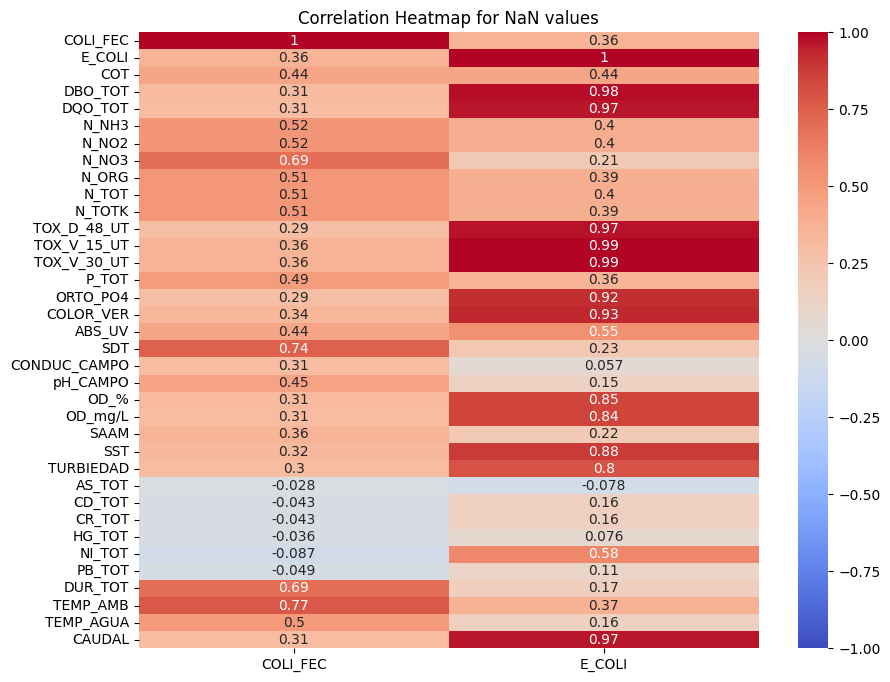

In [11]:
corr_null = nullity_correlation(df=df_pollulants, lst=['COLI_FEC', 'E_COLI'])
# corr_null

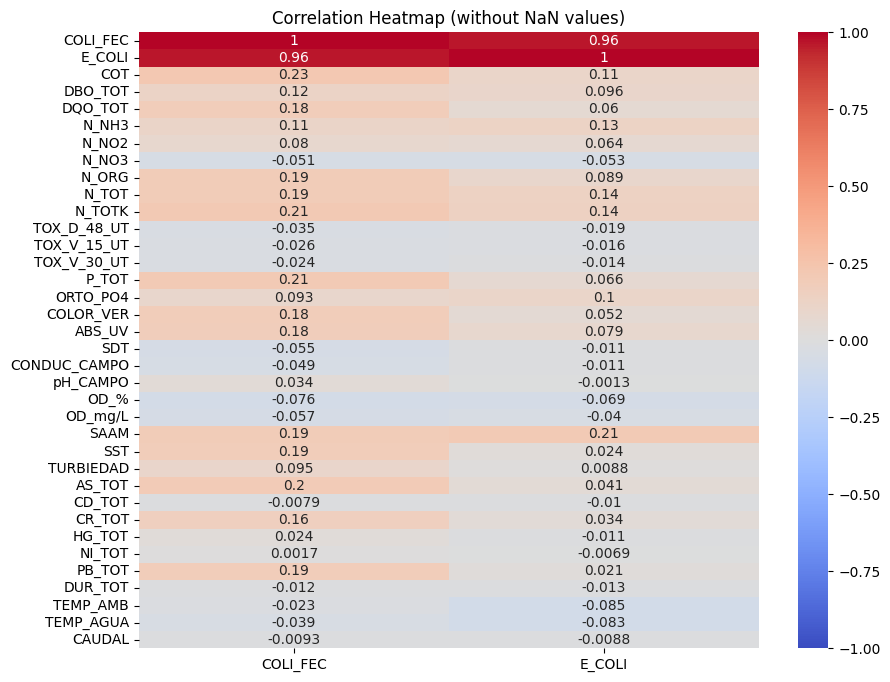

In [12]:
corr = nonnull_correlation(df_pollulants, lst=['COLI_FEC', 'E_COLI'])

In [13]:
# Function to select the best pairwaise correlation bewteen data correlation and nullity correlation
def best_corr_choice(df, lst, col, top_n=None, plthm_nonnull=True, plthm_null=True):
    corr = nonnull_correlation(df_pollulants, lst=lst, plthm=plthm_nonnull)
    corr_null = nullity_correlation(df=df_pollulants, lst=lst, plthm=plthm_null)

    mask = corr.index != col
    result = abs(corr.loc[mask, col] / corr_null.loc[mask, col])
    choice = result.sort_values(ascending=False).iloc[:top_n] if top_n else result.sort_values(ascending=False)
    
    return choice

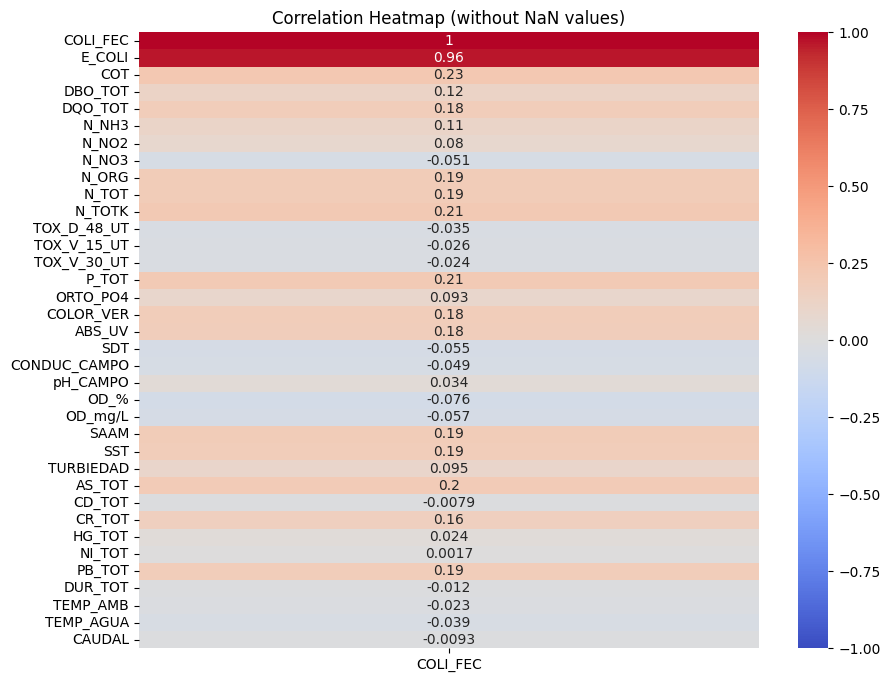

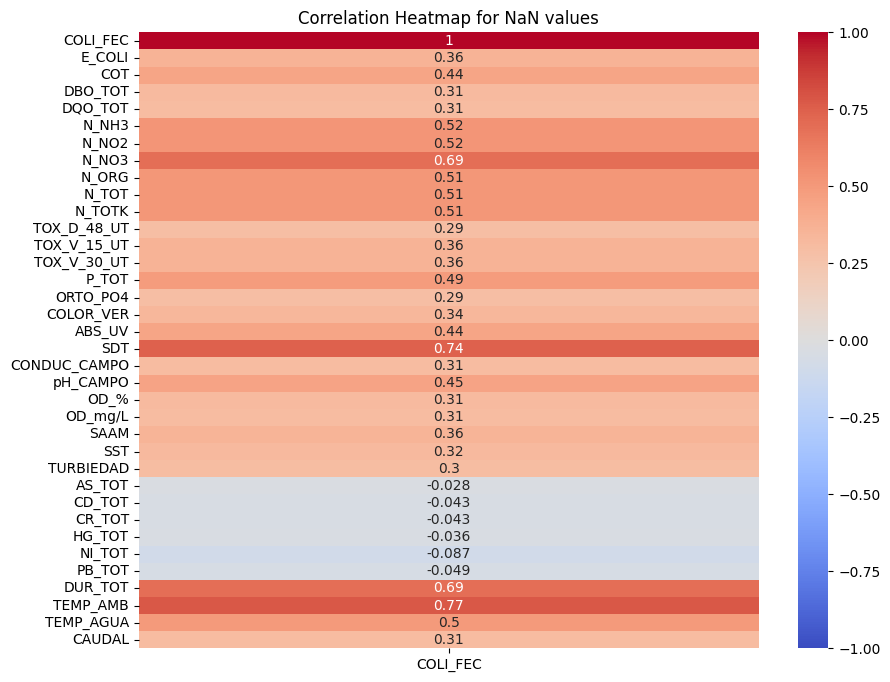

AS_TOT       6.967605
PB_TOT       3.839568
CR_TOT       3.801222
E_COLI       2.657821
HG_TOT       0.652756
DQO_TOT      0.579293
SST          0.573499
SAAM         0.544630
COLOR_VER    0.543821
COT          0.516306
Name: COLI_FEC, dtype: float64

In [14]:
best = best_corr_choice(df_pollulants, lst=['COLI_FEC'], col='COLI_FEC', top_n=10)
best

In [15]:
def imputation_methods(lst, df_pollulants, all_pollutants=False, top_n=None, poll_lst=None, plthm_nonnull=True, plthm_null=True):
    df_imputation_method = pd.DataFrame()
    
    for idx, poll in enumerate(lst):
        df_polls = pd.DataFrame()
        if all_pollutants:
            df_polls = df_pollulants
        elif(top_n):          
            plthm_nonnull_corr = plthm_nonnull if idx==0 else False
            plthm_null_corr = plthm_null if idx==0 else False

            best = best_corr_choice(df_pollulants, lst=lst, col=poll, top_n=top_n, plthm_nonnull=plthm_nonnull_corr, plthm_null=plthm_null_corr)
            s = [poll] + best.index.to_list()
            df_polls = df_pollulants[s]
        elif(poll_lst):

            if len(lst) > 1:
                raise RuntimeError('If you selected your custom best correlated pollulants, you can only choose one pollulant at a time to analyze')
            s = [poll] + poll_lst
            df_polls = df_pollulants[s]
            
        
        # Forward Fill
        df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)

        # BackFill
        df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)

        # KNN Based
        knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
        df_imputation_method[poll+'_knn'] = knn_imputer.fit_transform(df_pollulants[[poll]])

        # MICE
        mice_imputer = IterativeImputer(max_iter=100, random_state=0)
        imputed_values = mice_imputer.fit_transform(df_polls)
        df_imputation_method[poll+'_mice'] = imputed_values[:, df_polls.columns.get_loc(poll)]

        print(f'Forward Fill return {df_imputation_method[poll+'_ffill'].isna().sum()} missing values for {poll}')
        print(f'BackFill return {df_imputation_method[poll+'_bfill'].isna().sum()} missing values for {poll}')
        print(f'KNN return {df_imputation_method[poll+'_knn'].isna().sum()} missing values for {poll}')
        print(f'MICE return {df_imputation_method[poll+'_mice'].isna().sum()} missing values for {poll}')

    return df_imputation_method

In [16]:
chosen_poll = 'AS_TOT'

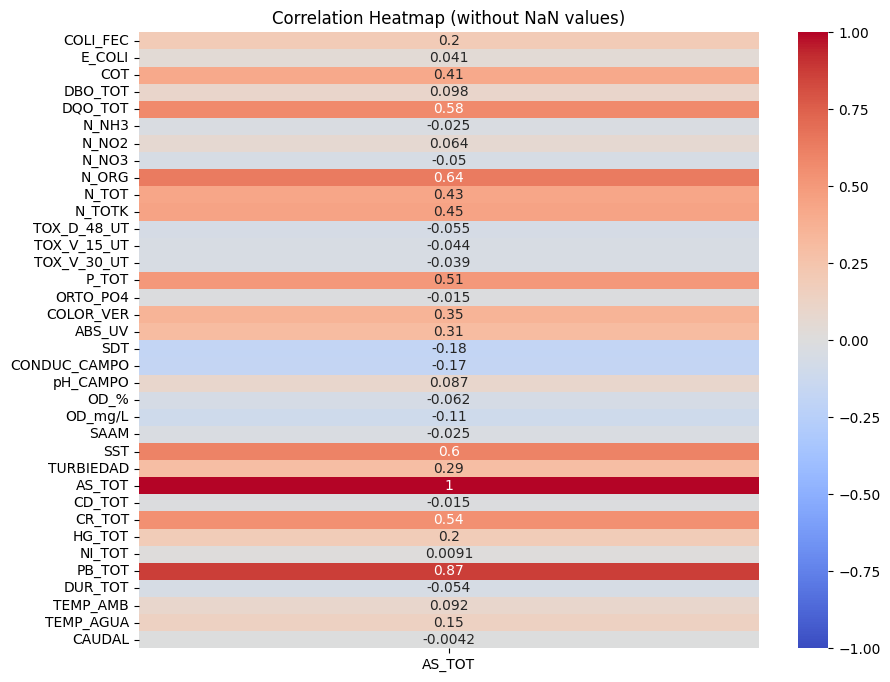

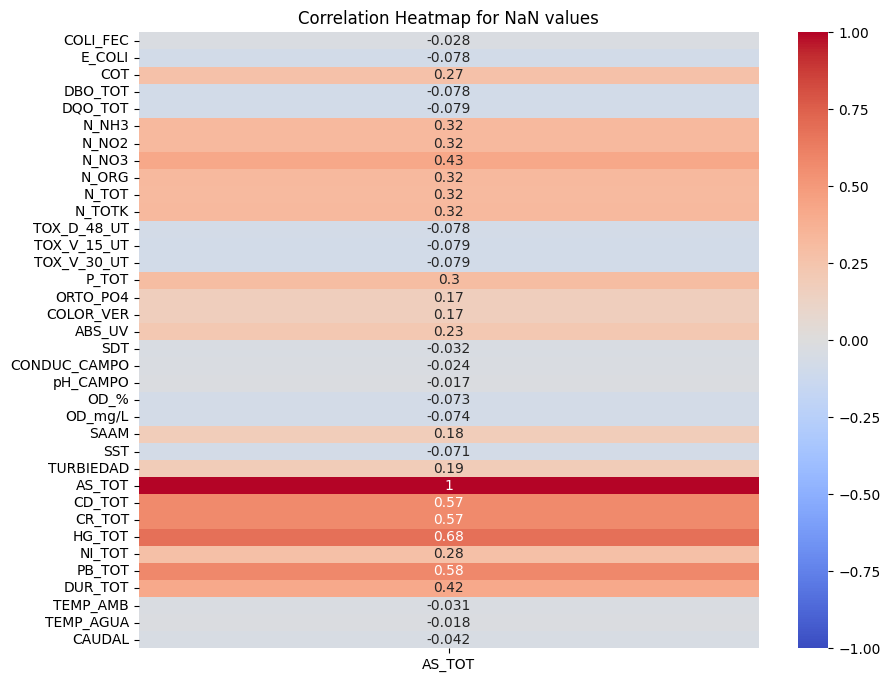

Forward Fill return 0 missing values for AS_TOT
BackFill return 0 missing values for AS_TOT
KNN return 0 missing values for AS_TOT
MICE return 0 missing values for AS_TOT


/tmp/ipykernel_10436/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_10436/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)


,AS_TOT_ffill,AS_TOT_bfill,AS_TOT_knn,AS_TOT_mice
0,0.0015,0.0015,0.0015,0.0015
1,0.0015,0.0015,0.0015,0.0015
2,0.0020,0.0020,0.0020,0.0020
3,0.0015,0.0015,0.0015,0.0015
4,0.0015,0.0015,0.0015,0.0015
...,...,...,...,...
468,0.0015,0.0015,0.0015,0.0015
469,0.0015,0.0015,0.0015,0.0015
470,0.0080,0.0080,0.0080,0.0080
471,0.0015,0.0015,0.0015,0.0015


In [17]:
df_imp = imputation_methods(lst=[chosen_poll], df_pollulants=df_pollulants, all_pollutants=False, top_n=10, poll_lst=None)
df_imp

In [18]:
# KDE graphs to compare the imputation methods
def plot_distribution(df, df_imp, poll, figsize=(18, 5)):
    sum_imp = df_imp.isna().sum()
    nonull = sum_imp[sum_imp == 0]
    poll_nonull = nonull.filter(like=poll)
    cols = 2
    rows = math.ceil(len(poll_nonull) / 2)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    axes = axes.flatten()

    for i, c in enumerate(poll_nonull.index):
        print(c)
        method = c.split('_', -1)[-1]
        sns.kdeplot(df[poll], label='Original distribution', fill=True, ax=axes[i])
        sns.kdeplot(df_imp[c], label=f'{method} distribution', fill=True, ax=axes[i])
        axes[i].set_title(f'Original distribution vs {method} distribution ({poll})')
        axes[i].legend()

    # Ajuste de diseño
    plt.tight_layout()
    plt.show()

AS_TOT_ffill
AS_TOT_bfill
AS_TOT_knn
AS_TOT_mice


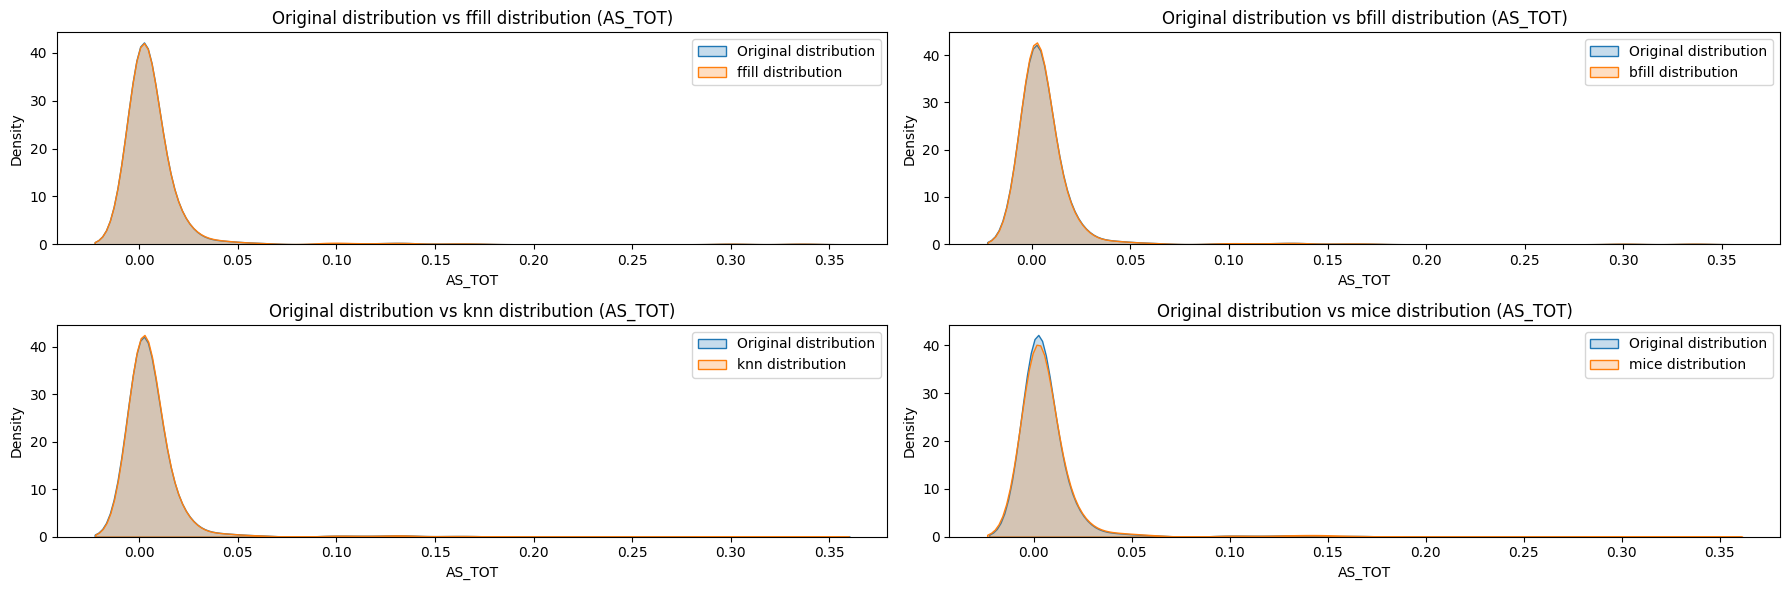

In [19]:
plot_distribution(df_drop_water_sonora, df_imp, chosen_poll, figsize=(18,6))

In [20]:
# Scatter graphs to compare the imputation methods
def plot_scatter(df, df_imp, poll, figsize=(18, 5)):
    sum_imp = df_imp.isna().sum()
    nonull = sum_imp[sum_imp == 0]
    poll_nonull = nonull.filter(like=poll)
    cols = 2
    rows = math.ceil(len(poll_nonull) / 2)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    axes = axes.flatten()

    for i, c in enumerate(poll_nonull.index):
        method = c.split('_', -1)[-1]
        sns.scatterplot(df[poll], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[i])
        sns.scatterplot(df_imp[c], label=f'Imputed data with {method}', alpha=0.6, s=80, color='orange', ax=axes[i])
        axes[i].set_title(f'Original data vs imputed data with {method} ({poll})')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

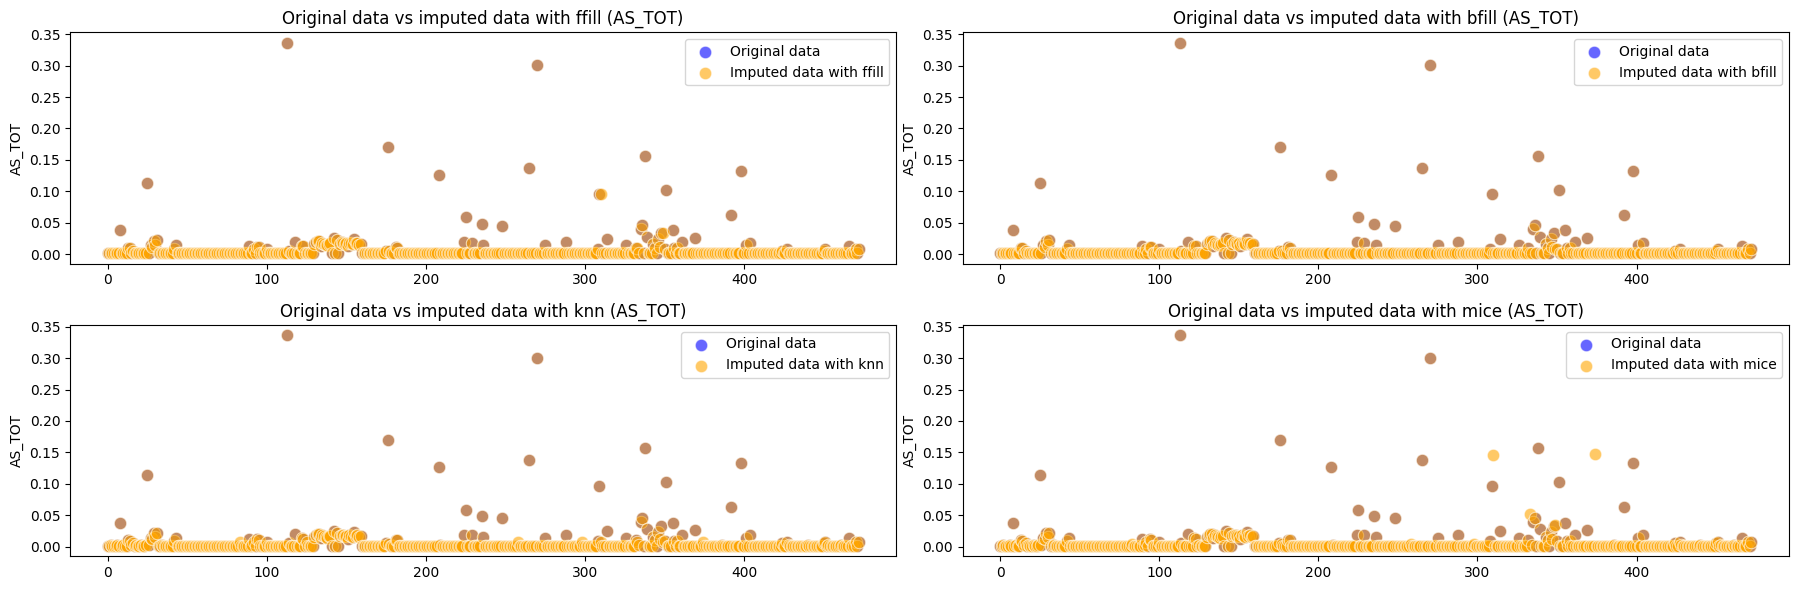

In [21]:
plot_scatter(df_drop_water_sonora, df_imp, chosen_poll, figsize=(18,6))

In [22]:
# Function to graph the results of outlier detection
def plot_outliers(df, column, estimates, title):
    split = column.rsplit('_', 1)
    m = split[-1]
    p = split[0]

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    # sns.set_style('whitegrid')

    # Minimum Covariance Determinant (MCD) robust
    ax1 = sns.scatterplot(
        x=range(len(df[column])),
        y=df[column], 
        hue=estimates['MCD'],
        palette='RdBu', 
        legend=False, 
        s=80, 
        ax=axes[0, 0]
    )
    # ax1.grid(False)
    norm1 = mpl.colors.Normalize(vmin=estimates['MCD'].min(), vmax=estimates['MCD'].max())
    sm1 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm1)
    sm1.set_array([])
    cax1 = fig.colorbar(sm1, ax=axes[0, 0], orientation="vertical", fraction=0.046, pad=0.04)
    axes[0, 0].set_title(f'Analysis of outliers using Minimum Covariance Determinant (MCD) {title}')
    axes[0, 0].set_ylabel(p)

    # Empirical Covariance (MLE) estimator
    ax2 = sns.scatterplot(
        x=range(len(df[column])),
        y=df[column], 
        hue=estimates['MLE'],
        palette='RdBu', 
        legend=False, 
        s=80, 
        ax=axes[0, 1]
    )
    # ax2.grid(True)
    norm2 = mpl.colors.Normalize(vmin=estimates['MLE'].min(), vmax=estimates['MLE'].max())
    sm2 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm2)
    sm2.set_array([])
    cax2 = fig.colorbar(sm2, ax=axes[0, 1], orientation="vertical", fraction=0.046, pad=0.04)
    axes[0, 1].set_title(f'Analysis of outliers using Empirical Covariance (MLE) {title}')
    axes[0, 1].set_ylabel(p)

    # Local Outlier Factor
    ax3 = sns.scatterplot(
        x=range(len(df[column])),
        y=df[column], 
        hue=estimates['LOF'],
        palette='RdBu', 
        legend=False, 
        s=80, 
        ax=axes[1, 0]
    )
    norm3 = mpl.colors.Normalize(vmin=estimates['LOF'].min(), vmax=estimates['LOF'].max())
    sm3 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm3)
    sm3.set_array([])
    cax3 = fig.colorbar(sm3, ax=axes[1, 0], orientation="vertical", fraction=0.046, pad=0.04)
    axes[1, 0].set_title(f'Analysis of outliers using Local Outlier Factor {title}')
    axes[1, 0].set_ylabel(p)

    # Isolation Forest estimator
    ax4 = sns.scatterplot(
        x=range(len(df[column])),
        y=df[column], 
        hue=estimates['IF'],
        palette='RdBu', 
        legend=False, 
        s=80, 
        ax=axes[1, 1]
    )
    norm4 = mpl.colors.Normalize(vmin=estimates['IF'].min(), vmax=estimates['IF'].max())
    sm4 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm4)
    sm4.set_array([])
    cax4 = fig.colorbar(sm4, ax=axes[1, 1], orientation="vertical", fraction=0.046, pad=0.04)
    axes[1, 1].set_title(f'Analysis of outliers using Isolation Forest {title}')
    axes[1, 1].set_ylabel(p)

    plt.tight_layout()
    
    plt.figure(figsize=(25, 7)) 
    plt.scatter(df_drop_water_sonora['FECHA REALIZACIÓN'], df_imp[column])
    plt.xlabel('Date')
    plt.ylabel(p)
    plt.title(f'{p} concentration over time')
    
    plt.show()

In [23]:
# Treatment of outliers using various method of outlier detection
def outlier_detection(df, method, poll, plot=True):
    column = '_'.join([method, poll])
    df_column = df[[column]]

    # Minimum Covariance Determinant (MCD) robust estimator
    robust_cov = MinCovDet(support_fraction=0.99).fit(df_column)
    estimate_MCD = robust_cov.mahalanobis(df_column)

    # Empirical Covariance (MLE) estimator
    emp_cov = EmpiricalCovariance().fit(df_column)
    estimate_MLE = emp_cov.mahalanobis(df_column)

    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=100)
    estimate_LOF = lof.fit_predict(df_column)

    # Isolation Forest estimator
    iso_forest = IsolationForest(
        contamination=0.013, 
        n_estimators=100, 
        warm_start=True
    ).fit(df_column)
    estimate_IF = iso_forest.predict(df_column)

    estimates = {
        "MCD": estimate_MCD,
        "MLE": estimate_MLE,
        "LOF": estimate_LOF,
        "IF": estimate_IF
    }

    if plot:
        split = column.rsplit('_', 1)
        m = split[-1]
        p = split[0]
        plot_outliers(df, column, estimates, title=f'in imputed data of {p} with {m}')

    return estimates

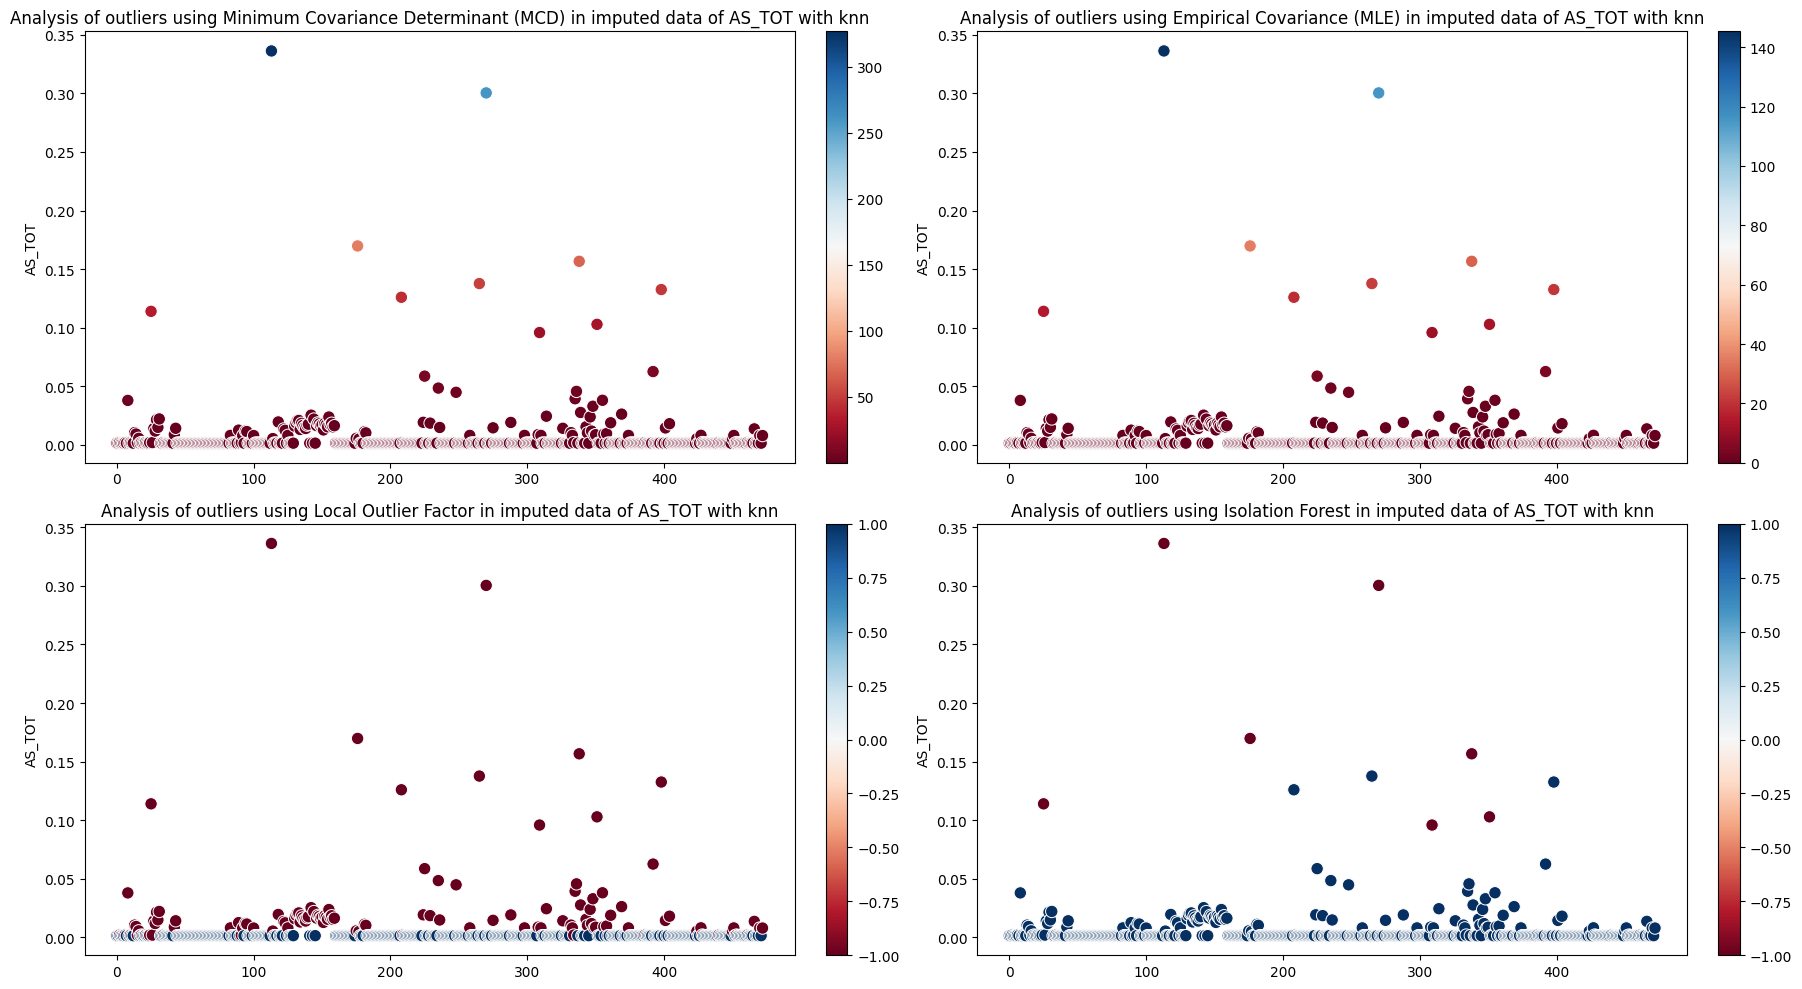

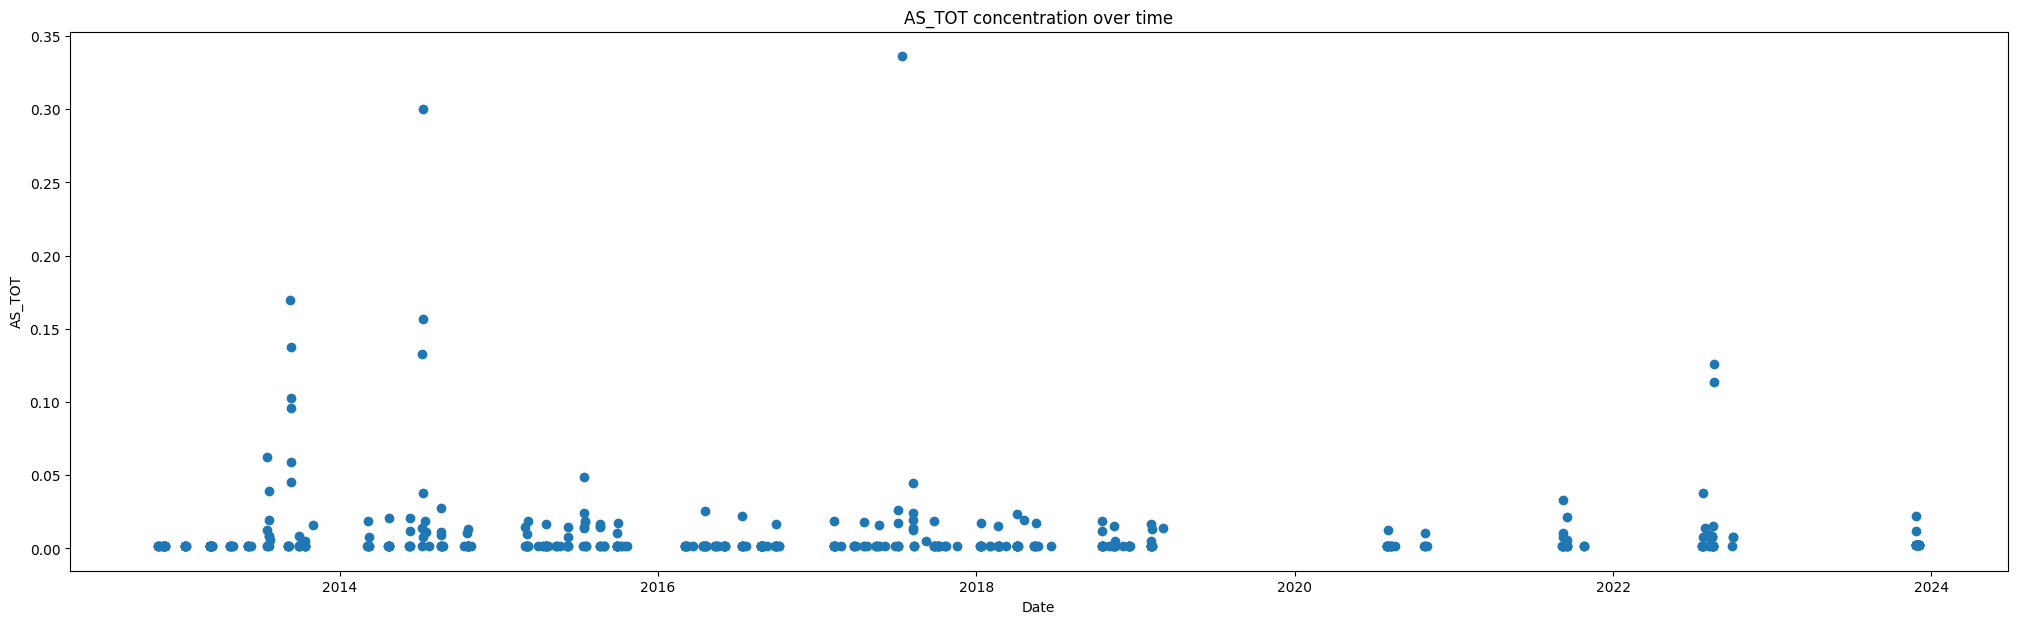

In [24]:
estimates = outlier_detection(df_imp, chosen_poll, 'knn')

In [25]:
def outlier_analysis(df, df_imp, estimates, method, threshold, poll, met_imp, plot=True):
    column = '_'.join([poll, met_imp])
    conditions = {
        'MCD': df_imp[estimates[method] >= threshold],
        'MLE': df_imp[estimates[method] >= threshold],
        'LOF': df_imp[(estimates[method] == threshold)],
        'IF': df_imp[(estimates[method] == threshold)]
    }
    
    # Obtener los outliers basados en el método
    if method not in conditions:
        raise ValueError("Method don't recognized. Use 'MCD', 'MLE', 'LOF' o 'IF'")
    
    outliers = conditions[method][column]
    data = {
        'latitude': [30.973333],
        'longitude': [-110.320278],
        'value': [200]
    }
    df_water = df[df_imp[column].isin(outliers)]
    
    if plot:
        df = pd.concat([df_water[['LATITUD', 'LONGITUD']], df_imp[df_imp[column].isin(outliers)][column]], axis=1)
        df2 = pd.DataFrame(data)

        # Convertir el DataFrame a un GeoDataFrame con puntos geoespaciales
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUD'], df['LATITUD']), crs="EPSG:4326")
        gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2['longitude'], df2['latitude']), crs="EPSG:4326")

        # Convertir el sistema de coordenadas a Web Mercator para añadir un mapa de fondo
        gdf = gdf.to_crs(epsg=3857)
        gdf2 = gdf2.to_crs(epsg=3857)

        scale = gdf[column].max() / 1000

        # Crear la figura y el gráfico
        fig, ax = plt.subplots(figsize=(15, 10))
        gdf.plot(ax=ax, markersize=gdf[column]/scale, color='blue', alpha=0.6, edgecolor='k', legend=True)
        gdf2.plot(ax=ax, markersize=gdf2['value'], color='red', alpha=0.6, edgecolor='k', legend=True)


        # Definir límites personalizados para el área a visualizar (ajusta según el área deseada)
        ax.set_xlim([gdf.geometry.x.min() - 100000, gdf.geometry.x.max() + 100000])
        ax.set_ylim([gdf.geometry.y.min() - 100000, gdf.geometry.y.max() + 100000])

        # Añadir el mapa de fondo con un proveedor alternativo
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

        # Ajustes adicionales
        plt.title(f"Geospatial graph of {poll} outliers")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.show()

    return df_water[['FECHA REALIZACIÓN', 'MUNICIPIO', 'CUERPO DE AGUA', 'TIPO CUERPO DE AGUA', 'LATITUD', 'LONGITUD', poll]]


    """ gdf.explore(
        marker_kwds={"radius": 25}
    ) """

/tmp/ipykernel_10436/417416579.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


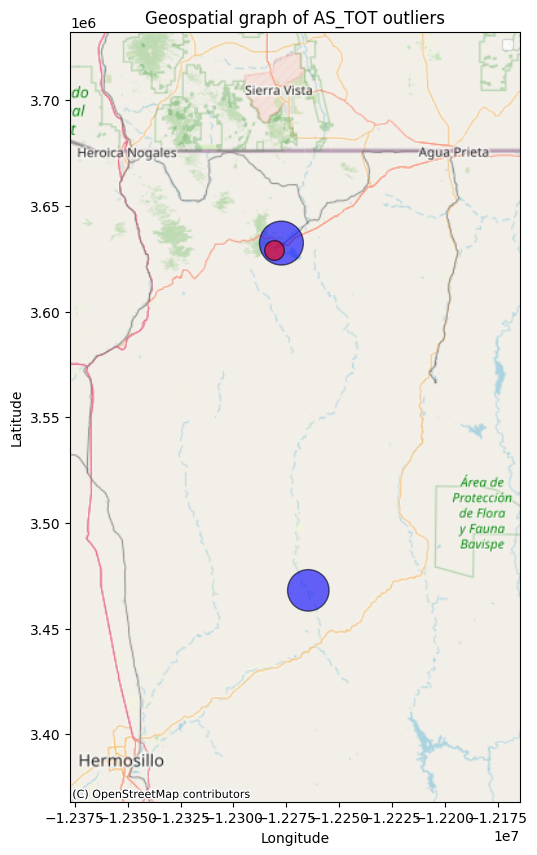

,FECHA REALIZACIÓN,MUNICIPIO,CUERPO DE AGUA,TIPO CUERPO DE AGUA,LATITUD,LONGITUD,AS_TOT
113,2017-07-13,CANANEA,ARROYO EL BARRILITO,LÓTICO (HUMEDAL),30.99713,-110.28877,0.3362
270,2014-07-10,BAVIÁCORA,RIO SONORA,LÓTICO,29.72369,-110.17441,0.3004


In [26]:
df_water = outlier_analysis(df_drop_water_sonora, df_imp, estimates, 'MLE', 80, chosen_poll, 'knn')
df_water

In [27]:
list_to_analysis = [
    {
        "poll": "SST",
        "imputation": {
            "method": "knn",
            "top_n": 1
        },
        "outlier": {
            "method": "IF",
            "threshold": -1,
            "support_fraction": None
        }
    },
    {
        "poll": "AS_TOT",
        "imputation": {
            "method": "knn",
            "top_n": 10
        },
        "outlier": {
            "method": "MLE",
            "threshold": 80,
            "support_fraction": 0.75
        }
    },
    {
        "poll": "CD_TOT",
        "imputation": {
            "method": "knn",
            "top_n": 10
        },
        "outlier": {
            "method": "MLE",
            "threshold": 150,
            "support_fraction": 0.9
        }
    },
    {
        "poll": "CR_TOT",
        "imputation": {
            "method": "mice",
            "top_n": 10
        },
        "outlier": {
            "method": "MLE",
            "threshold": 150,
            "support_fraction": 0.75
        }
    },
    {
        "poll": "HG_TOT",
        "imputation": {
            "method": "mice",
            "top_n": 15
        },
        "outlier": {
            "method": "MLE",
            "threshold": 200,
            "support_fraction": 0.99
        }
    },
    {
        "poll": "PB_TOT",
        "imputation": {
            "method": "knn",
            "top_n": 2
        },
        "outlier": {
            "method": "MLE",
            "threshold": 50,
            "support_fraction": 0.99
        }
    }
]

In [28]:
df_to_analysis = pd.DataFrame()
for idx in list_to_analysis:
    df_imp = imputation_methods(lst=[idx['poll']], df_pollulants=df_pollulants, all_pollutants=False, top_n=idx['imputation']['top_n'], poll_lst=None, plthm_nonnull=False, plthm_null=False)
    estimates = outlier_detection(df_imp, idx['poll'], idx['imputation']['method'], plot=False)
    df_water = outlier_analysis(df_drop_water_sonora, df_imp, estimates, idx['outlier']['method'], idx['outlier']['threshold'], idx['poll'], idx['imputation']['method'], plot=False)

    df_to_analysis = pd.concat([df_to_analysis, df_water], axis=0)


df_outliers = df_to_analysis.melt(
    id_vars=['FECHA REALIZACIÓN', 'MUNICIPIO', 'CUERPO DE AGUA', 'TIPO CUERPO DE AGUA', 'LATITUD', 'LONGITUD'],
    value_vars=['SST', 'AS_TOT', 'CD_TOT', 'CR_TOT', 'HG_TOT', 'PB_TOT'],
    var_name='CONTAMINANTE', 
    value_name='VALOR'
)
df_outliers = df_outliers.dropna(subset='VALOR')
df_outliers.sort_values(by='FECHA REALIZACIÓN')

/tmp/ipykernel_10436/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_10436/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)


Forward Fill return 0 missing values for SST
BackFill return 5 missing values for SST
KNN return 0 missing values for SST
MICE return 0 missing values for SST


/tmp/ipykernel_10436/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_10436/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)


Forward Fill return 0 missing values for AS_TOT
BackFill return 0 missing values for AS_TOT
KNN return 0 missing values for AS_TOT
MICE return 0 missing values for AS_TOT


/tmp/ipykernel_10436/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_10436/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)
/mnt/Data/Documents/Unison/1 Semestre/Ingeniería de Características/Projects/Sonora-River-Farming/Data-Science-Project/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Forward Fill return 0 missing values for CD_TOT
BackFill return 0 missing values for CD_TOT
KNN return 0 missing values for CD_TOT
MICE return 0 missing values for CD_TOT


/tmp/ipykernel_10436/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_10436/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)


Forward Fill return 0 missing values for CR_TOT
BackFill return 0 missing values for CR_TOT
KNN return 0 missing values for CR_TOT
MICE return 0 missing values for CR_TOT


/tmp/ipykernel_10436/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_10436/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)


Forward Fill return 0 missing values for HG_TOT
BackFill return 0 missing values for HG_TOT
KNN return 0 missing values for HG_TOT
MICE return 0 missing values for HG_TOT


/tmp/ipykernel_10436/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_10436/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)


Forward Fill return 0 missing values for PB_TOT
BackFill return 0 missing values for PB_TOT
KNN return 0 missing values for PB_TOT
MICE return 0 missing values for PB_TOT


,FECHA REALIZACIÓN,MUNICIPIO,CUERPO DE AGUA,TIPO CUERPO DE AGUA,LATITUD,LONGITUD,CONTAMINANTE,VALOR
43,2012-11-10,ACONCHI,RIO SONORA,LÓTICO,29.84478,-110.27754,CD_TOT,1.4230
44,2013-03-10,ACONCHI,RIO SONORA,LÓTICO,29.84478,-110.27754,CD_TOT,1.1780
98,2013-09-09,URES,RIO SONORA,LÓTICO,29.32107,-110.54156,PB_TOT,0.4678
101,2013-09-10,ARIZPE,RIO SONORA,LÓTICO,30.33503,-110.16534,PB_TOT,0.5888
99,2013-09-10,BAVIÁCORA,RIO SONORA,LÓTICO,29.72369,-110.17441,PB_TOT,0.6923
4,2013-09-10,ARIZPE,RIO SONORA,LÓTICO,30.33503,-110.16534,SST,5200.0000
100,2013-09-10,ACONCHI,RIO SONORA,LÓTICO (HUMEDAL),29.82440,-110.23701,PB_TOT,0.4413
80,2013-09-30,CANANEA,RIO SONORA,LÓTICO,30.95804,-110.18906,HG_TOT,0.0116
6,2014-07-09,ARIZPE,RIO BACANUCHI,LÓTICO,30.36813,-110.15751,SST,7575.0000
25,2014-07-10,BAVIÁCORA,RIO SONORA,LÓTICO,29.72369,-110.17441,AS_TOT,0.3004


In [76]:
mining_2013 = {
    "NOMBRE": [
        "La Caridad", "Cananea", "La Colorada", "Piedras Verdes", "María", "La Herradura",
        "Mulatos", "El Boludo", "Cerro Colorado", "Álamo Dorado", "Milpillas", "El Chanate", 
        "Santa Elena", "Lluvia de Oro", "Nochebuena", "Dipolo (Soledad)", "Las Mercedes", 
        "San Francisco", "San Felix", "El Volcán", "Cerro Prieto", "La Cienega", "Santa Gertrudis", 
        "El Pilar", "Picacho", "El Tigre Tailings", "Luz del Cobre/ San Antonio", "La India"
    ],
    "COORDENADAS_X": [
        638584, 564877, 542661, 697674, 559560, 322892, 720711, 426209, 420814, 731943, 
        554648, 412738, 580923, 496850, 342843, 317762, 548486, 488688, 341951, 666593, 
        533164, 424090, 543545, 531135, 587789, 670812, 632830, 707399
    ],
    "COORDENADAS_Y": [
        3354404, 3424645, 3185713, 3006208, 3432165, 3447355, 3170866, 3356230, 3343924, 
        2960388, 3442287, 3408647, 3321262, 3398347, 3433944, 3456270, 3355233, 3356408, 
        3386879, 3069254, 3365250, 3343378, 3388890, 3452470, 3384507, 3385665, 3167308, 
        3177281
    ],
    "EMPRESA": [
        "Mexicana de Cobre, S.A. de C.V.", "Buenavista del Cobre S.A. de C.V.", 
        "Pediment Gold Corp / Argonaut Gold Inc.", "Cobre del Mayo S.A. de C.V.", 
        "Minera María, S.A. de C.V.", "Newmont Mining Corp / Fresnillo PLC", 
        "Minas de Oro Nacional S.A. de C.V.", "Minera Secotec, S.A. de C.V.", 
        "Goldgroup Mining Inc.", "Pan American Silver Corp.", "Minera la Parreña, S.A. de C.V.", 
        "Aurico Gold Inc.", "Silver Crest Mines Inc / Sandstorm Resources LTD", 
        "NWM Mining Corporation", "Newmont Mining Corp / Fresnillo PLC", 
        "Newmont Mining Corp / Fresnillo PLC", "Yamana Gold Inc.", "TIMMINS (Gold Corp)", 
        "Mexus Enterprise, S.A. de C.V.", "AERCELOR Mittal Steel Company N.V.", 
        "Oroco Resources Corp", "Alto Group Holding Inc", "Animas Resources LTD", 
        "Mercator Minerals LTD", "Tara Gold Resources LTD", "Tara Minerals Corp", 
        "Zaruma Resources Inc.", "Agnico-Eagle Mines LTD"
    ],
    "MUNICIPIO": [
        "Nacozari", "Cananea", "La Colorada", "Álamos", "Cananea", "Caborca", 
        "Sahuaripa", "Trincheras", "Trincheras", "Álamos", "Santa Cruz", "Altar", 
        "Banamichi", "Magdalena de Kino", "Caborca", "Caborca", "Cucurpe", "Estación Llano", 
        "Caborca", "Rosario", "Cucurpe", "Arivechi", "Cucurpe", "Santa Cruz", 
        "Bacoachi", "Nacozari de García", "Soyopa", "Sahuaripa"
    ],
    "PRODUCCION_TON_DIA": [
        "90,000", "70,000", "4,000", None, None, "4,000", None, "7,000", None, 
        None, "55,000", None, None, None, None, None, None, None, None, None, 
        None, None, None, None, None, None, None, "16,000"
    ],
    "SUSTANCIA": [
        "Cu, Mo, Au, Ag", "Cu, Au, Ag", "Au", "Cu", 
        "Cu, Molibdeno", "Au", "Au", "Au", "Au", "Ag", "Cu", "Au", 
        "Au, Ag", "Au", "Au, Cu", "Au", "Au, Ag", "Au", 
        "Au, Ag", "Fe", "Au, Ag, Pb, Zn", "Au", "Cu", "Au, Cu", "Au", "Au, Ag", 
        "Au, Cu", "Au, Ag"
    ],
    "LATITUD": [
        30.2245, 30.9747, 28.7757, 27.1011, 31.0403, 31.1721, 28.6835, 30.3276, 
        30.1965, 26.7152, 31.1009, 30.7459, 29.9418, 30.6518, 31.0236, 31.2475, 
        30.6229, 30.6327, 30.5561, 27.6966, 30.4106, 30.2073, 30.6031, 31.1805, 
        30.5909, 30.5936, 28.5892, 28.6366
    ],
    "LONGITUD": [
        -109.6764, -110.3036, -110.5287, -108.9437, -110.2116, -112.1091, -109.6983, 
        -111.5589, -111.6438, -108.9921, -110.5555, -111.5625, -110.2068, -110.7752, 
        -111.3722, -112.1632, -111.0725, -111.2002, -112.0015, -112.0031, -111.4847, 
        -110.3194, -110.6358, -111.1914, -110.4427, -109.8862, -109.6412, -109.2025
    ]
}

mining_2017 = {
    "NOMBRE": [
        "La Caridad", "Cananea", "La Colorada", "Piedras Verdes", "María", 
        "La Herradura/Noche Buena", "Mulatos", "El Boludo", "Álamo Dorado", 
        "Milpillas", "El Chanate", "Santa Elena", "Lluvia de Oro/La Jojoba", 
        "Las Mercedes/Delivuar y La Lupita", "San Francisco", "El Volcán", 
        "Cerro Prieto", "La Fierrosa", "Nash", "Luz del Cobre/San Antonio", 
        "La India", "La Cuesta"
    ],
    "EMPRESA": [
        "Mexicana de Cobre, S.A. de C.V.", "Buenavista del Cobre S.A. de C.V.", 
        "Minera Pitalla S.A. de C.V./ Argonaut Gold Inc.", "Inventure Group, SA de CV/Frontier Copper Corp", 
        "Minera María, S.A. de C.V.", "Fresnillo PLC.", "Minas de Oro Nacional S.A. de C.V.", 
        "Minera Secotec, S.A. de C.V.", "Minera Corner Bay S.A. de C.V.", 
        "Compañía Minera la Parreña, S.A. de C.V.", "Álamos Gold", "Santa Elena S.A. de C.V.", 
        "Minera Columbia de México S.A. de C.V./ Nwm Mining Corporation", 
        "Premier Gold Mines", "Timmins Gold Corp México S.A. de C.V", 
        "ARCELOR Mittal Steel Company N.V.", "Goldgroup Mining Inc.", "New Best", 
        "G.E. Galaz S.A. de C.V.", "Minerales Libertad S.A. de C.V.", 
        "Agnico Sonora S.A. de C.V.", "Gaeso"
    ],
    "MUNICIPIO": [
        "Nacozari", "Cananea", "La Colorada", "Álamos", "Cananea", 
        "Caborca", "Sahuaripa", "Trincheras", "Álamos", "Santa Cruz", 
        "Altar", "Banamichi", "Magdalena de Kino", "Cucurpe", 
        "Estación Llano", "Rosario", "Cucurpe", "Bacanora", "Hermosillo", 
        "Soyopa", "Sahuaripa", "Bacanora"
    ],
    "PRODUCCION_TON_DIA": [
        "90,000", "188,000", "4,000", "15,000 ton/anual", None, 
        "4,000", "17,233", "7,000", "4,830", "6,700", "24,237", None, "6,263", 
        "2,000", "3,730 kg/anual", "6,625", None, None, None, "6,000 ton/anual", 
        "16,438", None
    ],
    "SUSTANCIA": [
        "Cu, Mo, Au, Ag", "Cu, Au, Ag, Zn", "Au", "Cu", "Cu, Mo, Au, Ag", 
        "Au", "Au", "Au", "Ag", "Cu", "Au", "Au, Ag", "Au, Ag", 
        "Au, Ag", "Au", "Fe", "Au, Ag, Pb, Zn", "Fe", "Fe", 
        "Cu, Au", "Au, Ag", "Fe"
    ],
    "COORDENADAS_X": [
        638495, 565000, 541348, 697265, 555596, 322338, 720711, 426298, 
        731943, 554648, 412708, 581154, 496580, 549281, 488688, 666993, 
        532488, 647842, 456782, 632921, 706305, 647707
    ],
    "COORDENADAS_Y": [
        3354540, 3425000, 3185856, 3006351, 3433580, 3443783, 3170866, 
        3349715, 2960388, 3442287, 3408165, 3321485, 3398872, 3355515, 
        3356408, 3069525, 3388221, 3205381, 3276821, 3164163, 3178867, 
        3201475
    ],

    "LATITUD": [
        30.2245, 30.9747, 28.7757, 27.1011, 31.0403, 
        31.1721, 28.6835, 30.3276, 26.7152, 31.1009, 
        30.7459, 29.9418, 30.6518, 30.6229, 30.6327, 
        27.6966, 30.4106, 28.6833, 29.0581, 28.5547, 
        28.6366, 28.5654
    ],
    "LONGITUD": [
        -109.6764, -110.3036, -110.5287, -108.9437, -110.2116, 
        -112.1091, -109.6983, -111.5589, -108.9921, -110.5555, 
        -111.5625, -110.2068, -110.7752, -110.6985, -111.2002, 
        -112.0031, -111.4847, -110.8722, -111.0444, -109.9257, 
        -109.2025, -109.5832
    ]
}

In [77]:
df_mining_2013 = pd.DataFrame(mining_2013)
df_mining_2017 = pd.DataFrame(mining_2017)

In [110]:
df_mining_2013.sort_values(by='MUNICIPIO')

,NOMBRE,COORDENADAS_X,COORDENADAS_Y,EMPRESA,MUNICIPIO,PRODUCCION_TON_DIA,SUSTANCIA,LATITUD,LONGITUD
11,El Chanate,412738,3408647,Aurico Gold Inc.,Altar,None,Au,30.7459,-111.5625
21,La Cienega,424090,3343378,Alto Group Holding Inc,Arivechi,None,Au,30.2073,-110.3194
24,Picacho,587789,3384507,Tara Gold Resources LTD,Bacoachi,None,Au,30.5909,-110.4427
12,Santa Elena,580923,3321262,Silver Crest Mines Inc / Sandstorm Resources LTD,Banamichi,None,"Au, Ag",29.9418,-110.2068
5,La Herradura,322892,3447355,Newmont Mining Corp / Fresnillo PLC,Caborca,"4,000",Au,31.1721,-112.1091
18,San Felix,341951,3386879,"Mexus Enterprise, S.A. de C.V.",Caborca,None,"Au, Ag",30.5561,-112.0015
14,Nochebuena,342843,3433944,Newmont Mining Corp / Fresnillo PLC,Caborca,None,"Au, Cu",31.0236,-111.3722
15,Dipolo (Soledad),317762,3456270,Newmont Mining Corp / Fresnillo PLC,Caborca,None,Au,31.2475,-112.1632
1,Cananea,564877,3424645,Buenavista del Cobre S.A. de C.V.,Cananea,"70,000","Cu, Au, Ag",30.9747,-110.3036
4,María,559560,3432165,"Minera María, S.A. de C.V.",Cananea,None,"Cu, Molibdeno",31.0403,-110.2116


In [101]:
def mining_river(outliers, poll, mining):
    path_river = os.getcwd()+'/river/red_hidrografica_250k.shp'
    origin = {
        'latitude': [30.973333],
        'longitude': [-110.320278],
        'value': [350]
    }
    df_outliers = outliers.loc[outliers['CONTAMINANTE'] == poll]    
    df_origin = pd.DataFrame(origin)
    substance_colors = {
        "Cu, Mo, Au, Ag": "blue",
        "Cu, Au, Ag, Zn": "green",
        "Au": "gold",
        "Cu": "red",
        "Au, Ag": "purple",
        "Fe": "brown",
        "Au, Ag, Pb, Zn": "orange",
        "Cu, Au": "cyan",
    }

    gdf_outliers = gpd.GeoDataFrame(df_outliers, geometry=gpd.points_from_xy(df_outliers['LONGITUD'], df_outliers['LATITUD']), crs="EPSG:4326").to_crs(epsg=3857)
    gdf_origin = gpd.GeoDataFrame(df_origin, geometry=gpd.points_from_xy(df_origin['longitude'], df_origin['latitude']), crs="EPSG:4326").to_crs(epsg=3857)
    gdf_river = gpd.read_file(path_river).to_crs(epsg=3857).to_crs(epsg=3857)
    gdf_mining = gpd.GeoDataFrame(mining, geometry=gpd.points_from_xy(mining['LONGITUD'], mining['LATITUD']), crs="EPSG:4326").to_crs(epsg=3857)
    gdf_sonora = gdf_river[gdf_river['NOMBRE'] == 'Sonora']
    gdf_bacanuchi = gdf_river[gdf_river['NOMBRE'] == 'Bacanuchi']
    scale = gdf_outliers['VALOR'].max() / 1000

    fig, ax = plt.subplots(figsize=(15, 10))
    
    gdf_river.plot(ax=ax, edgecolor="#ADD8E6", color="#ADD8E6")
    gdf_sonora.plot(ax=ax, edgecolor="blue")
    gdf_bacanuchi.plot(ax=ax, edgecolor="blue")
    gdf_outliers.plot(ax=ax, markersize=gdf_outliers['VALOR']/scale, color='blue', alpha=0.6, edgecolor='k', legend=True)
    gdf_origin.plot(ax=ax, markersize=gdf_origin['value'], marker='*', color='red', alpha=0.6, edgecolor='k', legend=True)
    # gdf_mining.plot(ax=ax, markersize=200, color='green', alpha=0.6, edgecolor='k', legend=True)
    
    for idx, row in gdf_mining.iterrows():
        color = substance_colors.get(row['SUSTANCIA'], 'grey') 
        gdf_mining[gdf_mining.index == idx].plot(ax=ax, color=color, markersize=200, alpha=0.6, edgecolor='k', legend=True)

    for idx, row in gdf_outliers.iterrows():
        date_only = pd.to_datetime(row['FECHA REALIZACIÓN']).date()
        label = f"{row['VALOR']}\n{date_only}\n{row['MUNICIPIO']}"
        ax.text(row.geometry.x + 2000, row.geometry.y + 2000, s=label, 
                fontsize=8, color='black', weight='bold', ha='left', va='bottom')

    
    substance_legend = [mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=10, label=substance) 
                for substance, color in substance_colors.items()]
    substance_legend.append(mlines.Line2D([], [], color='red', marker='*', linestyle='None', markersize=10, label='Origin of the spill'))
    
    plt.legend(handles=substance_legend, title="Legend", loc="upper left", bbox_to_anchor=(1, 1))

    # Establecer límites en el gráfico con un margen
    ax.set_xlim(-1.24*10**7, -1.22*10**7)
    ax.set_ylim(3.36*10**6, 3.65*10**6)
    # Añadir el mapa de fondo con un proveedor alternativo
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    # Ajustes adicionales
    plt.title(f"Geospatial graph of {poll} outliers, nearest mines, and the Sonora and Bacanuchi river basins")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    # plt.legend()
    plt.savefig(f"{poll}.png", format='png', bbox_inches='tight')
    plt.show()

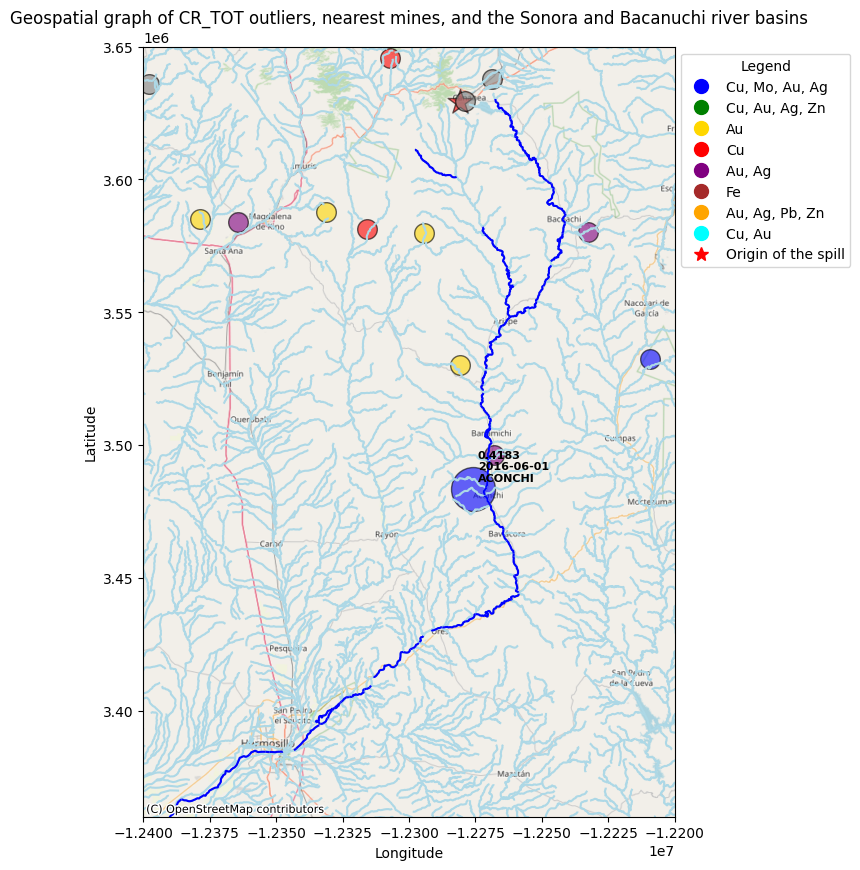

In [107]:
mining_river(df_outliers, "CR_TOT", df_mining_2013)

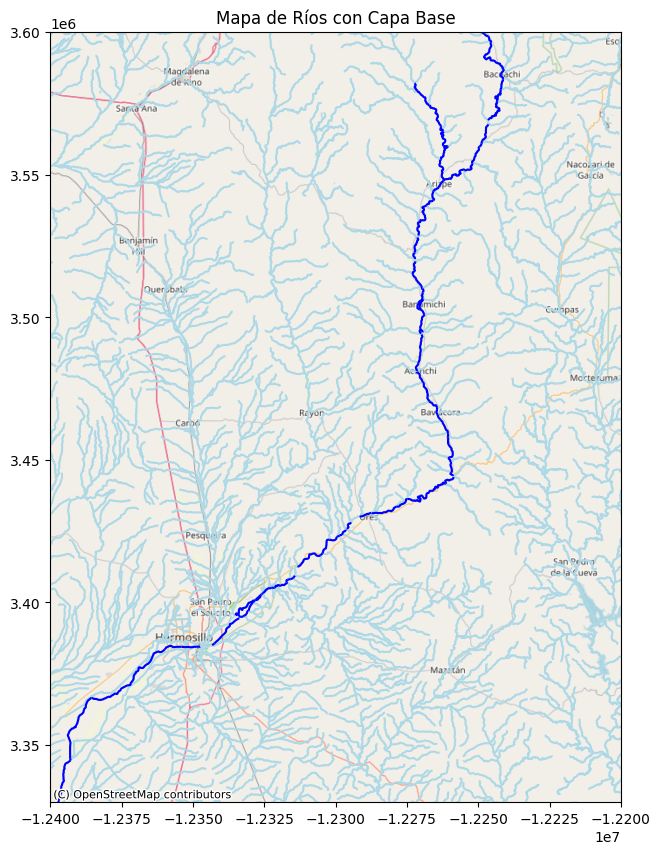

In [ ]:
# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 10))

subset_gdf = gdf[gdf['NOMBRE'] == 'Sonora']
subset_gdf2 = gdf[gdf['NOMBRE'] == 'Bacanuchi']
subset_gdf3 = gdf[(gdf['LENGTH'] > 2400) &
                  (gdf['LENGTH'] < 6200) &
                  (gdf['FC'] == 3271)]


gdf.plot(ax=ax, edgecolor="#ADD8E6", color="#ADD8E6")
subset_gdf.plot(ax=ax, edgecolor="blue")
subset_gdf2.plot(ax=ax, edgecolor="blue")


# gdf.plot(ax=ax, edgecolor="blue")
# Obtener los límites totales (xmin, ymin, xmax, ymax)
xmin, ymin, xmax, ymax = gdf.total_bounds

# Establecer límites en el gráfico con un margen
ax.set_xlim(-1.24*10**7, -1.22*10**7)
ax.set_ylim(3.33*10**6, 3.6*10**6)

# Añadir una capa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("Mapa de Ríos con Capa Base")
plt.show()

In [ ]:
gdf[(gdf['REDHIDRO_'] > gdf[gdf['NOMBRE'] == 'Sonora']['REDHIDRO_'].min()) &
                  (gdf['REDHIDRO_'] < gdf[gdf['NOMBRE'] == 'Sonora']['REDHIDRO_'].max()) &
                  (gdf['FC'] == 3271)]

,FNODE_,TNODE_,LENGTH,REDHIDRO_,REDHIDRO_I,FC,NOMBRE,ORDEN,C_DESAPA,TIPO,Ter_Gen,geometry
399,327,352,9459.759,400,400,3271,Las Parras,3,No aplica,Real,None,"LINESTRING (-12950212.28 3813503.156, -1295015..."
400,352,351,7273.550,401,401,3271,El Álamo,3,No aplica,Real,None,"LINESTRING (-12958750.741 3809793.969, -129590..."
403,360,316,9594.551,404,404,3271,None,1,No aplica,Real,Arroyo,"LINESTRING (-12904555.362 3814242.549, -129046..."
404,361,315,5257.604,405,405,3271,Santa Anita,1,No aplica,Real,None,"LINESTRING (-12998010.497 3804671.699, -129984..."
409,357,364,12317.527,410,410,3271,None,6,No aplica,Real,Arroyo,"LINESTRING (-12783670.66 3826022.292, -1278379..."
...,...,...,...,...,...,...,...,...,...,...,...,...
112937,114194,114224,15307.546,1129,1129,3271,Izapa,1,No aplica,Real,None,"LINESTRING (-10259179.154 1686496.899, -102594..."
112964,114233,114251,16546.247,1129,1129,3271,Juan Manuel,1,No aplica,Real,None,"LINESTRING (-10275393.474 1666717.854, -102755..."
112970,114246,114256,10457.420,1129,1129,3271,None,1,Granular,Real,Arroyo,"LINESTRING (-10263198.844 1659223.416, -102632..."
112990,114272,114273,4449.634,1129,1129,3271,None,2,No aplica,Real,Arroyo,"LINESTRING (-10267969.398 1639035.187, -102683..."


In [ ]:
gdf['NOMBRE'].str.contains('La Junta')

0          None
1          None
2          None
3          None
4          None
          ...  
112989     None
112990     None
112991     None
112992    False
112993    False
Name: NOMBRE, Length: 112994, dtype: object

In [ ]:
gdf[(gdf['FC'] == 3271) & (gdf['NOMBRE'].str.contains('La Junta'))]

AttributeError: 'DataFrame' object has no attribute 'str'

In [ ]:
gdf[gdf['Ter_Gen'] == None]

,FNODE_,TNODE_,LENGTH,REDHIDRO_,REDHIDRO_I,FC,NOMBRE,ORDEN,C_DESAPA,TIPO,Ter_Gen,geometry


In [ ]:
gdf[gdf['NOMBRE'] == 'Sonora']['REDHIDRO_'].max()

np.int32(9855)

In [ ]:
gdf[gdf['NOMBRE'] == 'Sonora'].head(50)

,FNODE_,TNODE_,LENGTH,REDHIDRO_,REDHIDRO_I,FC,NOMBRE,ORDEN,C_DESAPA,TIPO,Ter_Gen,geometry
396,320,356,3548.451,397,397,3272,Sonora,6,No aplica,Real,None,"LINESTRING (-12784862.116 3829725.106, -127838..."
737,624,682,4578.844,738,738,3272,Sonora,1,No aplica,Real,None,"LINESTRING (-12795118.441 3794923.231, -127951..."
750,682,690,560.632,751,751,3272,Sonora,6,No aplica,Real,None,"LINESTRING (-12794612.378 3790024.982, -127945..."
819,690,747,4075.588,820,820,3272,Sonora,1,No aplica,Real,None,"LINESTRING (-12794621.865 3789377.746, -127950..."
833,756,746,585.613,834,834,3272,Sonora,6,No aplica,Real,None,"LINESTRING (-12796453.728 3784280.448, -127968..."
838,747,756,873.009,839,839,3272,Sonora,6,No aplica,Real,None,"LINESTRING (-12795909.075 3784781.197, -127959..."
903,746,819,6986.905,904,904,3272,Sonora,1,No aplica,Real,None,"LINESTRING (-12796877.246 3784823.877, -127970..."
960,830,862,3340.763,961,961,3272,Sonora,1,No aplica,Real,None,"LINESTRING (-12800386.795 3778136.901, -128004..."
987,862,884,1467.073,988,988,3272,Sonora,1,No aplica,Real,None,"LINESTRING (-12799514.348 3774659.499, -127994..."
3986,3949,4069,5936.810,3987,3987,3272,Sonora,2,No aplica,Real,None,"LINESTRING (-12267425.058 3630312.655, -122674..."


En minas que extraen Cobre, Molibdeno, Oro, Plata y Zinc, es común encontrar una variedad de otros minerales y elementos traza debido a la asociación geoquímica de estos metales en la naturaleza. Aquí tienes algunos de los minerales y elementos adicionales que suelen estar presentes en minas de estos metales:
1. Minas de Cobre
    * Azufre: Forma sulfuros como la calcopirita y la bornita.
    * Hierro: Asociado en minerales como la pirita (FeS₂) y la magnetita.
    * Oro y Plata: Frecuentemente presentes como subproductos en algunos depósitos de cobre.
    * Arsénico: Se encuentra en sulfuros como la arsenopirita.
    * Plomo y Zinc: En ocasiones presentes en las capas superiores de ciertos depósitos de cobre.

2. Minas de Molibdeno
    * Cobre: Muchas minas de molibdeno también contienen cobre, especialmente en forma de calcopirita.
    * Azufre: En sulfuros como la molibdenita (MoS₂).
    * Wolframio (Tungsteno): Puede encontrarse en depósitos de molibdeno, especialmente en granitos asociados.
    * Rhenio: Elemento raro presente en la molibdenita en pequeñas cantidades, valioso como subproducto.

3. Minas de Oro
    * Plata: Frecuentemente asociada con el oro en depósitos epigenéticos.
    * Cuarzo: Mineral de ganga común en vetas de oro.
    * Antimonio: Presente en minerales como la estibnita (Sb₂S₃).
    * Arsénico: Asociado en minerales como la arsenopirita (FeAsS).
    * Telurio: A menudo en forma de telururos de oro como calaverita (AuTe₂).

4. Minas de Plata
    * Oro: Frecuentemente encontrado junto a la plata en depósitos de vetas.
    * Cobre, Plomo y Zinc: Minerales de cobre, plomo y zinc están comúnmente asociados, formando minerales como galena (PbS) y esfalerita (ZnS).
    * Azufre: Forma sulfuros con plata, como la argentita (Ag₂S).
    * Antimonio y Arsénico: Común en sulfuros complejos como la tetraedrita ((Cu,Fe)₁₂Sb₄S₁₃).

5. Minas de Zinc
    * Plomo: Generalmente asociado en forma de galena (PbS).
    * Cobre: A veces presente como calcopirita (CuFeS₂).
    * Hierro: Asociado en la forma de pirita y marcasita (ambos FeS₂).
    * Cadmio: Frecuentemente encontrado como impureza en minerales de zinc como la esfalerita.
    * Manganeso: Puede encontrarse en depósitos hidrotermales junto al zinc.

Estos minerales y elementos suelen estar presentes debido a las condiciones de formación de los depósitos y la química de los fluidos hidrotermales. Además, muchos de ellos se extraen como subproductos, dependiendo de la rentabilidad de su recuperación.

# PARA ABAJO SON PRUEBAS

In [ ]:
outliers = df_imp.loc[estimates['IF'] == -1, 'DBO_TOT_knn']

data = {
    'latitude': [30.973333],
    'longitude': [-110.320278],
    'value': [200]
}
df_water = df_drop_water_sonora[df_imp['DBO_TOT_knn'].isin(outliers)]
df = pd.concat([df_water[['LATITUD', 'LONGITUD']], df_imp[df_imp['DBO_TOT_knn'].isin(outliers)]['DBO_TOT_knn']], axis=1)
df2 = pd.DataFrame(data)

print(df_water[['FECHA REALIZACIÓN', 'DBO_TOT']])

# Convertir el DataFrame a un GeoDataFrame con puntos geoespaciales
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUD'], df['LATITUD']), crs="EPSG:4326")
gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2['longitude'], df2['latitude']), crs="EPSG:4326")

# Convertir el sistema de coordenadas a Web Mercator para añadir un mapa de fondo
gdf = gdf.to_crs(epsg=3857)
gdf2 = gdf2.to_crs(epsg=3857)

# Crear la figura y el gráfico
fig, ax = plt.subplots(figsize=(15, 10))
gdf.plot(ax=ax, markersize=gdf['DBO_TOT_knn']*10, color='blue', alpha=0.6, edgecolor='k', legend=True)
gdf2.plot(ax=ax, markersize=gdf2['value'], color='red', alpha=0.6, edgecolor='k', legend=True)


# Definir límites personalizados para el área a visualizar (ajusta según el área deseada)
ax.set_xlim([gdf.geometry.x.min() - 100000, gdf.geometry.x.max() + 100000])
ax.set_ylim([gdf.geometry.y.min() - 100000, gdf.geometry.y.max() + 100000])

# Añadir el mapa de fondo con un proveedor alternativo
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Ajustes adicionales
plt.title("Gráfico Geoespacial de Puntos con Tamaño Basado en un Valor")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.show()


gdf.explore(
    marker_kwds={"radius": 25},
    tooltip='DBO_TOT_knn'
)

KeyError: 'DBO_TOT_knn'

In [ ]:
print(df_imp[df_imp.filter(like='E_COLI', axis=0).columns])

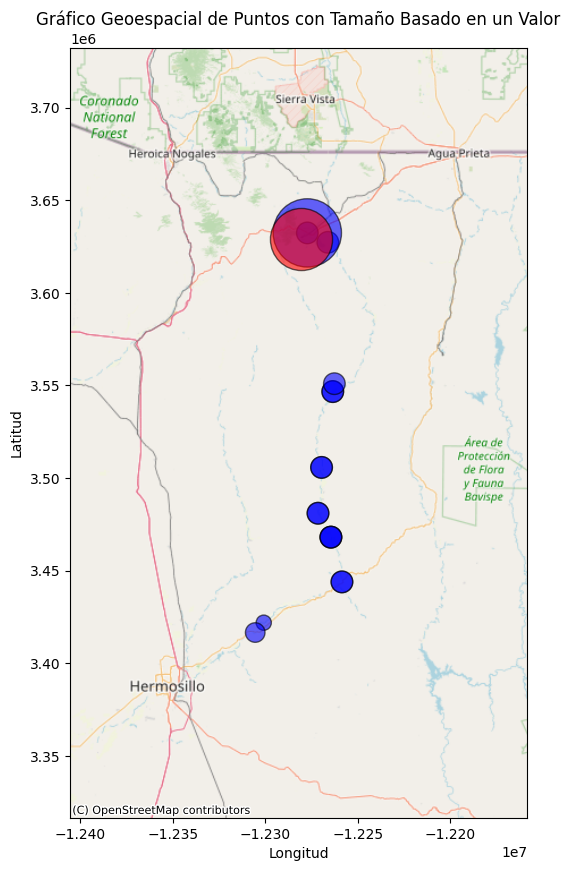

In [ ]:
# Ejemplo de datos
data = {
    'latitude': [30.973333],
    'longitude': [-110.320278],
    'value': [1000000]  # Este es el valor que afectará el tamaño del punto
}
df = df_drop_water_sonora[df_drop_water_sonora['COLI_FEC'] > 100000][['LATITUD', 'LONGITUD', 'COLI_FEC']]
df2 = pd.DataFrame(data)

# Convertir el DataFrame a un GeoDataFrame con puntos geoespaciales
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUD'], df['LATITUD']), crs="EPSG:4326")
gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2['longitude'], df2['latitude']), crs="EPSG:4326")

# Convertir el sistema de coordenadas a Web Mercator para añadir un mapa de fondo
gdf = gdf.to_crs(epsg=3857)
gdf2 = gdf2.to_crs(epsg=3857)

# Crear la figura y el gráfico
fig, ax = plt.subplots(figsize=(15, 10))
gdf.plot(ax=ax, markersize=gdf['COLI_FEC']*0.001, color='blue', alpha=0.6, edgecolor='k', legend=True)
gdf2.plot(ax=ax, markersize=gdf2['value']*0.002, color='red', alpha=0.6, edgecolor='k', legend=True)


# Definir límites personalizados para el área a visualizar (ajusta según el área deseada)
ax.set_xlim([gdf.geometry.x.min() - 100000, gdf.geometry.x.max() + 100000])
ax.set_ylim([gdf.geometry.y.min() - 100000, gdf.geometry.y.max() + 100000])

# Añadir el mapa de fondo con un proveedor alternativo
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Ajustes adicionales
plt.title("Gráfico Geoespacial de Puntos con Tamaño Basado en un Valor")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


In [ ]:
sns.scatterplot(df_imputation_method.loc[estimate_IF_COLI_FEC_ffill == 1, 'COLI_FEC_ffill'])


In [ ]:
pd.merge(df_imputation_method['COLI_FEC_mice'], df_imputation_method['COLI_FEC_knn'], left_index=True, right_index=True)

NameError: name 'df_imputation_method' is not defined

In [ ]:
estimate_IF_COLI_FEC_mice == 1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
# comp = 

df_imputation_method.loc[estimate_IF_COLI_FEC_mice == 1, 'COLI_FEC_mice'] 

0         10.000000
1         10.000000
2      18169.156411
3       1658.000000
4         10.000000
           ...     
468       31.000000
469       10.000000
470       10.000000
471       10.000000
472      148.000000
Name: COLI_FEC_mice, Length: 468, dtype: float64

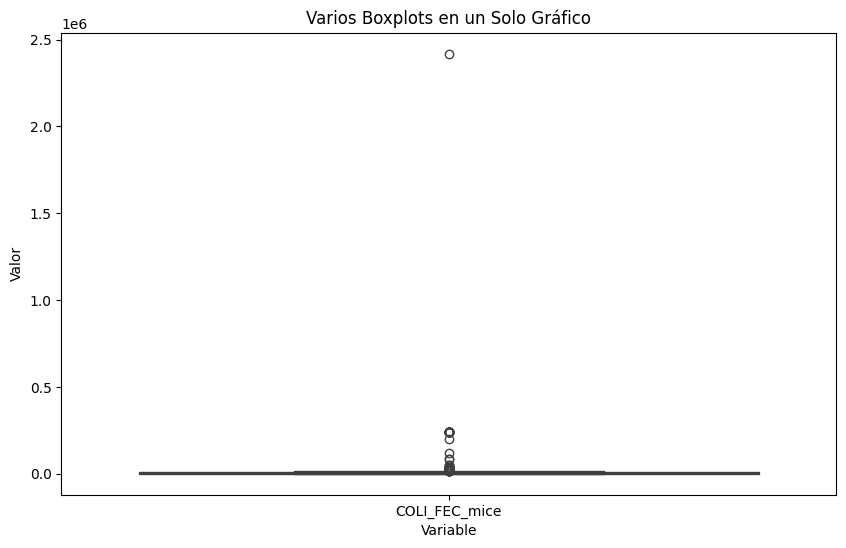

In [ ]:
# Ejemplo de datos
data = {
    'Variable1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Variable2': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'Variable3': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
}
df = pd.concat([df_imputation_method['COLI_FEC_mice'], df_imputation_method.loc[estimate_IF_COLI_FEC_mice == 1, 'COLI_FEC_mice']], axis=1)

# Convertir el DataFrame a un formato largo (long format) para usarlo con Seaborn
df_long = df.melt(var_name='Variable', value_name='Valor')

# Crear el gráfico de boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Variable', y='Valor', data=df_long)
plt.title('Varios Boxplots en un Solo Gráfico')
plt.show()

<Axes: ylabel='COLI_FEC_ffill'>

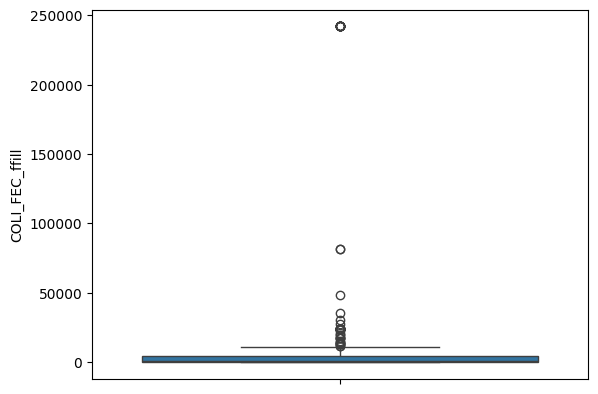

In [ ]:
# Outliers

sns.boxplot(y=df_imputation_method.loc[estimate_IF_COLI_FEC_ffill == 1, 'COLI_FEC_ffill'])

<Axes: ylabel='COLI_FEC_ffill'>

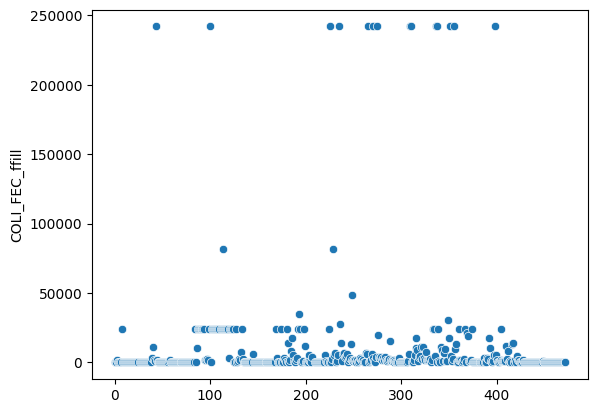

In [ ]:
sns.scatterplot(df_imputation_method.loc[estimate_IF_COLI_FEC_ffill == 1, 'COLI_FEC_ffill'])


In [ ]:
df_drop_water_sonora[df_drop_water_sonora['COLI_FEC'] > 100000]

,CLAVE SITIO,ESTADO,MUNICIPIO,CUERPO DE AGUA,TIPO CUERPO DE AGUA,SUBTIPO CUERPO AGUA,LATITUD,LONGITUD,FECHA REALIZACIÓN,COLI_FEC,...,AS_TOT,CD_TOT,CR_TOT,HG_TOT,NI_TOT,PB_TOT,DUR_TOT,TEMP_AMB,TEMP_AGUA,CAUDAL
25,MET-045,SONORA,URES,RIO SONORA,LÓTICO,RÍO,29.36277,-110.50018,2022-08-20,120330.0,...,0.1140,0.001301,0.0740,0.000600,0.09400,0.24800,NaN,27.0,25.0,18321.0
43,OCNOR3987,SONORA,CANANEA,RIO SONORA,LÓTICO,RÍO,30.95804,-110.18906,2014-07-09,241960.0,...,0.0142,0.001301,0.0074,0.000310,0.01120,0.03570,200.000,32.0,26.6,8.0
100,OCNOR3989,SONORA,CANANEA,ARROYO EL BARRILITO,LÓTICO (HUMEDAL),ARROYO,30.99713,-110.28877,2015-06-08,241960.0,...,0.0080,0.002200,0.0012,0.000201,0.00042,0.00154,251.940,34.0,25.1,42.4
110,OCNOR3989,SONORA,CANANEA,ARROYO EL BARRILITO,LÓTICO (HUMEDAL),ARROYO,30.99713,-110.28877,2017-02-24,2419600.0,...,0.0015,0.006300,0.0012,0.000201,0.01160,0.00154,435.040,17.0,14.8,169.9
208,OCNOR4017,SONORA,URES,RIO SONORA,LÓTICO,RÍO,29.32107,-110.54156,2022-08-20,198630.0,...,0.1260,0.001301,0.1780,0.000600,0.11200,0.26200,NaN,27.0,25.0,17404.0
225,OCNOR4019,SONORA,BAVIÁCORA,RIO SONORA,LÓTICO,RÍO,29.53502,-110.12087,2013-09-10,241960.0,...,0.0587,0.001301,0.0614,0.000300,0.07090,0.21990,223.972,34.5,28.2,10240.0
235,OCNOR4019,SONORA,BAVIÁCORA,RIO SONORA,LÓTICO,RÍO,29.53502,-110.12087,2015-07-15,241960.0,...,0.0485,0.001301,0.0277,0.000256,0.05050,0.00154,1054.970,33.0,29.8,1170.0
265,OCNOR4020,SONORA,BAVIÁCORA,RIO SONORA,LÓTICO,RÍO,29.72369,-110.17441,2013-09-10,241960.0,...,0.1377,0.010500,0.0532,0.000900,0.07050,0.69230,240.718,35.4,29.0,11200.0
270,OCNOR4020,SONORA,BAVIÁCORA,RIO SONORA,LÓTICO,RÍO,29.72369,-110.17441,2014-07-10,241960.0,...,0.3004,0.025200,0.1881,0.000150,0.34310,NaN,NaN,34.0,32.4,3900.0
275,OCNOR4020,SONORA,BAVIÁCORA,RIO SONORA,LÓTICO,RÍO,29.72369,-110.17441,2015-07-15,241960.0,...,0.0146,0.001301,0.0145,0.000201,0.01800,0.00154,298.320,38.0,29.4,780.0


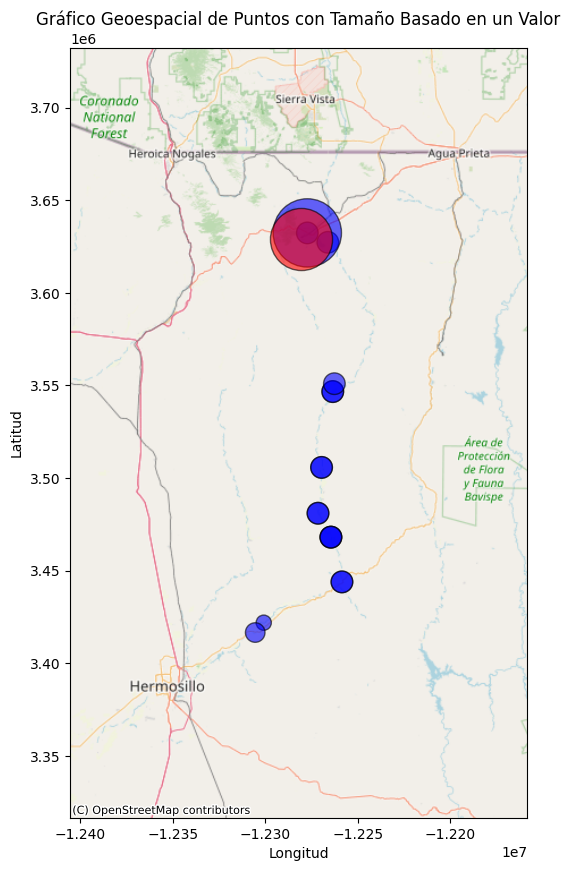

In [ ]:
# Ejemplo de datos
data = {
    'latitude': [30.973333],
    'longitude': [-110.320278],
    'value': [1000000]  # Este es el valor que afectará el tamaño del punto
}
df = df_drop_water_sonora[df_drop_water_sonora['COLI_FEC'] > 100000][['LATITUD', 'LONGITUD', 'COLI_FEC']]
df2 = pd.DataFrame(data)

# Convertir el DataFrame a un GeoDataFrame con puntos geoespaciales
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUD'], df['LATITUD']), crs="EPSG:4326")
gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2['longitude'], df2['latitude']), crs="EPSG:4326")

# Convertir el sistema de coordenadas a Web Mercator para añadir un mapa de fondo
gdf = gdf.to_crs(epsg=3857)
gdf2 = gdf2.to_crs(epsg=3857)

# Crear la figura y el gráfico
fig, ax = plt.subplots(figsize=(15, 10))
gdf.plot(ax=ax, markersize=gdf['COLI_FEC']*0.001, color='blue', alpha=0.6, edgecolor='k', legend=True)
gdf2.plot(ax=ax, markersize=gdf2['value']*0.002, color='red', alpha=0.6, edgecolor='k', legend=True)


# Definir límites personalizados para el área a visualizar (ajusta según el área deseada)
ax.set_xlim([gdf.geometry.x.min() - 100000, gdf.geometry.x.max() + 100000])
ax.set_ylim([gdf.geometry.y.min() - 100000, gdf.geometry.y.max() + 100000])

# Añadir el mapa de fondo con un proveedor alternativo
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Ajustes adicionales
plt.title("Gráfico Geoespacial de Puntos con Tamaño Basado en un Valor")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


In [ ]:
df_drop_water_sonora.sort_values('COLI_FEC', ascending=False).head(100)

,CLAVE SITIO,ESTADO,MUNICIPIO,CUERPO DE AGUA,TIPO CUERPO DE AGUA,SUBTIPO CUERPO AGUA,LATITUD,LONGITUD,FECHA REALIZACIÓN,COLI_FEC,...,AS_TOT,CD_TOT,CR_TOT,HG_TOT,NI_TOT,PB_TOT,DUR_TOT,TEMP_AMB,TEMP_AGUA,CAUDAL
110,OCNOR3989,SONORA,CANANEA,ARROYO EL BARRILITO,LÓTICO (HUMEDAL),ARROYO,30.99713,-110.28877,2017-02-24,2419600.0,...,0.0015,0.006300,0.0012,0.000201,0.01160,0.00154,435.040,17.0,14.8,169.9
351,OCNOR4024,SONORA,ARIZPE,RIO SONORA,LÓTICO,RÍO,30.33503,-110.16534,2013-09-10,241960.0,...,0.1029,0.001301,0.2526,0.000700,0.16430,0.58880,NaN,25.7,23.9,4740.0
43,OCNOR3987,SONORA,CANANEA,RIO SONORA,LÓTICO,RÍO,30.95804,-110.18906,2014-07-09,241960.0,...,0.0142,0.001301,0.0074,0.000310,0.01120,0.03570,200.000,32.0,26.6,8.0
355,OCNOR4024,SONORA,ARIZPE,RIO SONORA,LÓTICO,RÍO,30.33503,-110.16534,2014-07-10,241960.0,...,0.0381,0.003700,0.0344,0.000710,0.05210,0.11280,344.600,35.0,34.8,800.0
336,OCNOR4023,SONORA,BANÁMICHI,RIO SONORA,LÓTICO (HUMEDAL),RÍO,30.01704,-110.21963,2013-09-10,241960.0,...,0.0457,0.001301,0.0443,0.001200,0.03670,0.16500,188.388,31.5,28.0,3580.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,OCNOR4026,SONORA,ARIZPE,RIO BACANUCHI,LÓTICO,RÍO,30.36813,-110.15751,2016-09-28,8164.0,...,0.0015,0.001301,0.0203,0.000201,0.00042,0.00154,289.000,32.0,24.4,290.0
185,OCNOR4017,SONORA,URES,RIO SONORA,LÓTICO,RÍO,29.32107,-110.54156,2015-06-09,8164.0,...,0.0015,0.001301,0.0012,0.000201,0.35500,0.00154,395.350,36.0,32.8,53.5
132,OCNOR3990,SONORA,ACONCHI,RIO SONORA,LÓTICO,RÍO,29.84478,-110.27754,2014-04-23,7270.0,...,0.0207,0.001301,0.0012,0.000201,0.00042,0.00154,103.000,29.0,34.2,5.0
326,OCNOR4022,SONORA,ACONCHI,RIO SONORA,LÓTICO (HUMEDAL),RÍO,29.82440,-110.23701,2017-08-08,7270.0,...,0.0142,0.001301,0.0012,0.000201,0.00042,0.00154,326.980,42.0,33.2,432.8
